# Figure 5.B. Reduction in Wolbachia release ratios enabled by prior suppression

In [478]:
from scipy.integrate import odeint
import numpy as np
import matplotlib as mat
import matplotlib.pyplot as plt
from scipy import integrate as sp
import seaborn as sns
from tabulate import tabulate
import pandas as pd
import time
import os

### 1. Set up model
Parameters:

In [479]:
# MOSQUITO
alphaO=0.5  # rate that eggs hatch into larvae
alphaL=0.18  # rate that larvae pupate
alphaP=1  # rate that pupae eclose
phi=500*(1/14)    # number eggs laid per mosquito per day
muO=0.01    # daily death rate of eggs
muL=0.1*alphaL    # daily death rate of larvae
muP=0.1*alphaP     # pupae death rate
muM=1/14     # adult mosquito death rate
muF=1/14     # adult female mosquito death rate

# density-dependence via Bellows 1981:
AA=1   # determines the density at which mortality remains proportionate
BB=0.5   # determines the 'abruptness' of density-dependence

# WOLBACHIA
fCI=0.012   # prop of cytoplasmic incompatibility that fails 'sigma'
MT=0 #0.11    # prop of wolbachia females that don't successfully maternally transfer 'omega'
c=0.5      # mating competitiveness of released wolbachia males
cv = 0.128   #coverage of adulticide - 0.128 recovers 80% within 3 weeks from one pulse
e=1.2      # relative mortality of wolbachia adults compared to wild adults
RR=1 #0.02915       # release ratio of wolbachia eggs to wild type eggs
RRsupp=1      # release ratio of wolbachia eggs to wild type eggs for suppression techniques

Initial conditions: (equilibrium values previously defined in Supp)

In [480]:
O0=15947.608023052446
OW0=0
rOW0=0
OS0=0
L0=40271.71074193975
LW0=0
rLW0=0
LS0=0
P0=32.67541200187585
PW0=0
rPW0=0
PS0=0
M0=228.72754035145144
MW0=0
MS0=0
F0=228.72754035145144
FW0=0

Wolbachia release function:

In [481]:
start_wol = 200

def pulseN(t, start_wol=start_wol, releasenumber=5, frequency=14):    
    for i in range(0,releasenumber,1):
        if round(t) == start_wol + (frequency*i):
            return O0
    else:
        return 0

Suppression functions:

In [482]:
# IIT

def IIT(t, releasenumber=5, frequency=7, end=start_wol):
    for i in range(0,releasenumber,1):
        if round(t) == (end-frequency) - (frequency*i):
            return 0 #M0+F0
    else:
        return 0
        
RRsupp = 10.5

In [483]:
# SIT / RIDL

switch = 0 #0 for SIT; 1 for RIDL

def SIT(t, releasenumber=5, frequency=7, end=start_wol):    
    for i in range(0,releasenumber,1):
        if round(t) == (end-frequency) - (frequency*i):
            return 0 #M0+F0
    else:
        return 0

    
#RRsupp = 10.7 #1.865

In [484]:
# Environmental management

start_em=start_wol-(7*5)    #193,186,179,172,165, 158,151,144,137,130
stop_em=200
em_eff= 1 #0.526
#default 1 / 0.2(80%) / 0.5(50%) / 0.8(20%) / 0.526(47.4%literature)

def em(t):
    if round(t) < start_em:     #start
        return 1
    elif round(t) > stop_em:    #stop releases
        return 1
    else:
        return em_eff

In [485]:
# Larvicides (e.g. guppies)

start_lv=start_wol-(7*5)  # 193,186,179,172,165, 158,151,144,137,130
stop_lv=200
lv_eff= 1 #5.95

def lv(t):
    if round(t) < start_lv:     #start
        return 1
    elif round(t) > stop_lv:    #stop releases
        return 1
    else:
        return lv_eff

# to reach a new equilibrium:
# based on pupae being 99 at eq - 80% 19.8 / 50% 49.5 / 20% 79.2 / 44% 65.34 / 70% 29.7
# default 1 / 19.2(80%) / 7.6(50%) / 2.97(20%) / 6.42(44% literature) / 5.8(70% old)
# parameter that kills proportion of pupae (wild and wol)

# based on pupae being 33 at eq - 44% = 4.03

In [486]:
# Adulticide

h = [] #needed to set adulticide pulses
for i in range(-4, 1, 1):
    h.append((start_wol-7) + (7*i))

def ad(t):    
    ad_eff = 0 #4.9 #0.455
    if round(t) < h[0]:
        return 0
    elif round(t) > h[0]+0.01 and round(t) < h[1]:
        return 0
    elif round(t) > h[1]+0.01 and round(t) < h[2]:
        return 0
    elif round(t) > h[2]+0.01 and round(t) < h[3]:
        return 0
    elif round(t) > h[3]+0.01 and round(t) < h[4]:
        return 0
    elif round(t) > h[4]+0.01: # and round(t) < h[5]:
        return 0
#    elif round(t) > h[5]+0.01 and round(t) < h[6]:
#        return 0
#    elif round(t) > h[6]+0.01 and round(t) < h[7]:
#        return 0
#    elif round(t) > h[7]+0.01 and round(t) < h[8]:
#        return 0
#    elif round(t) > h[8]+0.01 and round(t) < h[9]:
#        return 0
#    elif round(t) > h[9]+0.01:
#        return 0
    else:
        return ad_eff

# NEW efficacy (fixed brackets)
# 4.9 = 90%
    
# efficacy
# 3 = ~90% | 1.9 = ~80% | 1.38 = ~70% | 1.03 = ~60% | 0.77 = ~50%
# 0.56 = ~40% | 0.39 = ~30% | 0.24 = ~20% | 0.11 = ~10%

Model:

In [487]:
def deriv(y, t, fCI, MT, c, e, phi, alphaO, muO, AA, BB, alphaL, alphaP, muP, muM, muF, RR, RRsupp, pulseN, IIT, SIT, em, lv, ad, cv, switch):
    
    O, OW, rOW, OS, L, LW, rLW, LS, P, PW, rPW, PS, M, MW, MS, F, FW = y
    
    #MOSQUITOES
    
    allfemales = 1+F+FW
    allmales = 1+M+MW+(MS*c)
    
    F_nothing = F + FW*MT 
    M_nothing = M + MW*fCI 
    
    F_wol = FW*(1-MT)
    
    #Eggs
    dOdt = em(t) * phi * F_nothing * M_nothing/allmales - alphaO*O - lv(t)*muO*O # eggs laid * females no-wol * (males no_wol / all males) (aka prop no-wol males)
    dOWdt = em(t) * phi * F_wol * (M+MW)/allmales - alphaO*OW - lv(t)*muO*OW 
    drOWdt = pulseN(t)*RR - alphaO*rOW - muO*rOW
    dOSdt = phi * allfemales * (MS*c)/allmales - alphaO*OS - muO*OS
    
    #Larvae
    dLdt =  alphaO*O - alphaL*L - lv(t)*muL*L
    dLWdt = alphaO*OW - alphaL*LW - lv(t)*muL*LW
    drLWdt = alphaO*rOW - alphaL*rLW - muL*rLW
    dLSdt = switch*alphaO*OS - alphaL*LS - muL*LS
    
    #Pupae 
    dPdt =  alphaL*(L/(1+((AA*(L+LW+LS))**BB))) - alphaP*P - lv(t)*muP*P 
    dPWdt = alphaL*(LW/(1+((AA*(L+LW+LS))**BB))) - alphaP*PW - lv(t)*muP*PW
    drPWdt = alphaL*(rLW/(1+((AA*(rLW))**BB))) - alphaP*rPW - muP*rPW 
    dPSdt = alphaL*(LS/(1+((AA*(L+LW+LS))**BB))) - alphaP*PS - muP*PS
        
    #Adult
    dMdt =  .5*alphaP*P - muM*M - ad(t)*M*cv
    dMWdt = IIT(t)*RRsupp + .5*alphaP*(PW+rPW) - muM*1.2*MW - ad(t)*MW*cv
    dMSdt = SIT(t)*RRsupp + .5*alphaP*PS - muM*1.2*MS
    
    dFdt =  .5*alphaP*P - muF*F - ad(t)*F*cv
    dFWdt = .5*alphaP*(PW+rPW) - muF*1.2*FW - ad(t)*FW*cv

    return dOdt, dOWdt, drOWdt, dOSdt, dLdt, dLWdt, drLWdt, dLSdt, dPdt, dPWdt, drPWdt, dPSdt, dMdt, dMWdt, dMSdt, dFdt, dFWdt

Model prerequisites:

In [488]:
t = np.linspace(0, 1500, 1501) # grid of time points (in days)
y0 = O0, OW0, rOW0, OS0, L0, LW0, rLW0, LS0, P0, PW0, rPW0, PS0, M0, MW0, MS0, F0, FW0 # initial condition vector

Run model:

In [489]:
ret = odeint(deriv, y0, t,args=(fCI, MT, c, e, phi, alphaO, muO, AA, BB, alphaL, alphaP, muP, muM, muF, RR, RRsupp, pulseN, IIT, SIT, em, lv, ad, cv, switch),hmax=1)

O, OW, rOW, OS, L, LW, rLW, LS, P, PW, rPW, PS, M, MW, MS, F, FW = ret.T

Visual check all suppression functions are off and Wolbachia functions is on: (should see Wolbachia come to fixation from day 200)

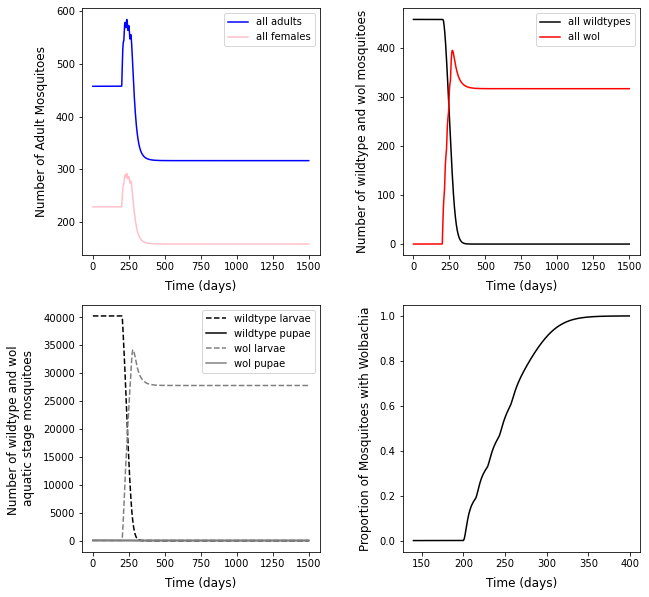

In [490]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=[10,10])

ax1.plot(t, F+FW+M+MW, 'blue', label='all adults')
ax1.plot(t, F+FW, 'pink', label='all females')
ax1.set_xlabel("Time (days)",fontsize=12, labelpad=8)
ax1.set_ylabel("Number of Adult Mosquitoes",fontsize=12, labelpad=8)
ax1.legend()

ax2.plot(t, M+F, 'black', label='all wildtypes')
ax2.plot(t, MW+FW, 'red', label='all wol')
ax2.set_xlabel("Time (days)",fontsize=12, labelpad=8)
ax2.set_ylabel("Number of wildtype and wol mosquitoes",fontsize=12, labelpad=8)
ax2.legend()

ax3.plot(t, L, 'black', linestyle='dashed', label='wildtype larvae')
ax3.plot(t, P, 'black', label='wildtype pupae')
ax3.plot(t, LW, 'grey', linestyle='dashed', label='wol larvae')
ax3.plot(t, PW, 'grey', label='wol pupae')
ax3.set_xlabel("Time (days)",fontsize=12, labelpad=8)
ax3.set_ylabel("Number of wildtype and wol \naquatic stage mosquitoes",fontsize=12, labelpad=8)
ax3.legend()

ax4.plot(t[140:400], (MW[140:400]+FW[140:400])/(MW[140:400]+FW[140:400]+M[140:400]+F[140:400]), 'black')
plt.xticks([150,200,250,300,350,400])
ax4.set_xlabel("Time (days)",fontsize=12, labelpad=8)
ax4.set_ylabel("Proportion of Mosquitoes with Wolbachia",fontsize=12, labelpad=8)


plt.subplots_adjust(wspace=.35)

#plt.savefig('wolAedesDemo-KT', dpi=300, facecolor='w', edgecolor='w',
#        orientation='portrait', format=None, transparent=False, bbox_inches=None, pad_inches=0.1, metadata=None)

In [491]:
filepath = os.path.abspath(os.getcwd())

### 2.a. Data collection: minimum Wolbachia RR with each suppression for fixation after different periods
### No suppression:

In [492]:
start_time = time.time()

RR_vec = [0.00047,0.00134,0.00258,0.00418,0.00612,0.00842,0.01108,0.01408,0.01745,0.02115,0.0252,0.0296,0.03437,0.03945,0.04495,0.0507,0.0569,0.0634,0.0703,0.0775,0.085,0.093,0.10125,0.1098,0.1188,0.1281,0.1378,0.1478,0.1582,0.169,0.18,0.1915,0.203,0.215,0.2277,0.2405,0.2538,0.2672,0.2811,0.2953]
zoo=[] #capture results here
start_wol=200

for i in RR_vec:
        
    RR = i
        
    # run the model
    t = np.linspace(0, 1500, 1501) # Grid of time points (in days)
    y0 = O0, OW0, rOW0, OS0, L0, LW0, rLW0, LS0, P0, PW0, rPW0, PS0, M0, MW0, MS0, F0, FW0 # Init condition vector
    ret= odeint(deriv, y0, t,args=(fCI, MT, c, e, phi, alphaO, muO, AA, BB, alphaL, alphaP, muP, muM, muF, RR, RRsupp, pulseN, IIT, SIT, em, lv, ad, cv, switch),hmax=1)
    O, OW, rOW, OS, L, LW, rLW, LS, P, PW, rPW, PS, M, MW, MS, F, FW = ret.T

    # get output
    total = MW+FW+M+F
    prop = (MW+FW)/(MW+FW+M+F)
    
    
    fix = np.argwhere(prop > 0.95)
    if sum(fix) > 0:
        min_fix = min(fix)-start_wol
        min_fix = min_fix.tolist()
    else:
        min_fix = [99999] #occurs if no fixation
        
    zoo.append(min_fix)

current_time = time.time()
elapsed_time = current_time - start_time
print('processing time:',round(elapsed_time,2),'seconds')

processing time: 5.41 seconds


In [493]:
zoo2 = [f for sublist in zoo for f in sublist] #flatten
sixmonth = next(x for x, val in enumerate(zoo2) if val <= 182.5) #within 6 months
RR_choosenosupp = RR_vec[sixmonth]
RR_choosenosupp
## returns error if there is no fixation

0.18

### RIDL:

In [494]:
RIDL_df = pd.read_csv(f'{filepath}/RIDL_df.csv')

In [495]:
switch = 1 #0 for SIT; 1 for RIDL

def SIT(t, releasenumber=1, frequency=7, end=start_wol):    
    for i in range(0,releasenumber,1):
        if round(t) == (end-frequency) - (frequency*i):
            return M0+F0
    else:
        return 0

RRsupp = list(RIDL_df.loc[RIDL_df['Target efficacy'] == 45, 'RRsupp value'])
RRsupp = RRsupp[0] 

In [496]:
start_time = time.time()

RR_vec = [0.00047,0.00134,0.00258,0.00418,0.00612,0.00842,0.01108,0.01408,0.01745,0.02115,0.0252,0.0296,0.03437,0.03945,0.04495,0.0507,0.0569,0.0634,0.0703,0.0775,0.085,0.093,0.10125,0.1098,0.1188,0.1281,0.1378,0.1478,0.1582,0.169,0.18,0.1915,0.203,0.215,0.2277,0.2405,0.2538,0.2672,0.2811,0.2953]
zoo=[] #capture results here
start_wol=200

for i in RR_vec:
        
    RR = i
        
    # run the model
    t = np.linspace(0, 1500, 1501) # Grid of time points (in days)
    y0 = O0, OW0, rOW0, OS0, L0, LW0, rLW0, LS0, P0, PW0, rPW0, PS0, M0, MW0, MS0, F0, FW0 # Init condition vector
    ret= odeint(deriv, y0, t,args=(fCI, MT, c, e, phi, alphaO, muO, AA, BB, alphaL, alphaP, muP, muM, muF, RR, RRsupp, pulseN, IIT, SIT, em, lv, ad, cv, switch),hmax=1)
    O, OW, rOW, OS, L, LW, rLW, LS, P, PW, rPW, PS, M, MW, MS, F, FW = ret.T

    # get output
    total = MW+FW+M+F
    prop = (MW+FW)/(MW+FW+M+F)
    
    
    fix = np.argwhere(prop > 0.95)
    if sum(fix) > 0:
        min_fix = min(fix)-start_wol
        min_fix = min_fix.tolist()
    else:
        min_fix = [99999] #occurs if no fixation
        
    zoo.append(min_fix)

current_time = time.time()
elapsed_time = current_time - start_time
print('processing time:',round(elapsed_time,2),'seconds')

processing time: 5.85 seconds


In [497]:
zoo2 = [f for sublist in zoo for f in sublist] #flatten
sixmonth = next(x for x, val in enumerate(zoo2) if val <= 182.5) #within 6 months
RIDL_choose1wk = RR_vec[sixmonth]
RIDL_choose1wk

0.1478

In [498]:
switch = 1 #0 for SIT; 1 for RIDL

def SIT(t, releasenumber=2, frequency=7, end=start_wol):    
    for i in range(0,releasenumber,1):
        if round(t) == (end-frequency) - (frequency*i):
            return M0+F0
    else:
        return 0

RRsupp = list(RIDL_df.loc[RIDL_df['Target efficacy'] == 45, 'RRsupp value'])
RRsupp = RRsupp[0] 

In [499]:
start_time = time.time()

RR_vec = [0.00047,0.00134,0.00258,0.00418,0.00612,0.00842,0.01108,0.01408,0.01745,0.02115,0.0252,0.0296,0.03437,0.03945,0.04495,0.0507,0.0569,0.0634,0.0703,0.0775,0.085,0.093,0.10125,0.1098,0.1188,0.1281,0.1378,0.1478,0.1582,0.169,0.18,0.1915,0.203,0.215,0.2277,0.2405,0.2538,0.2672,0.2811,0.2953]
zoo=[] #capture results here
start_wol=200

for i in RR_vec:
        
    RR = i
        
    # run the model
    t = np.linspace(0, 1500, 1501) # Grid of time points (in days)
    y0 = O0, OW0, rOW0, OS0, L0, LW0, rLW0, LS0, P0, PW0, rPW0, PS0, M0, MW0, MS0, F0, FW0 # Init condition vector
    ret= odeint(deriv, y0, t,args=(fCI, MT, c, e, phi, alphaO, muO, AA, BB, alphaL, alphaP, muP, muM, muF, RR, RRsupp, pulseN, IIT, SIT, em, lv, ad, cv, switch),hmax=1)
    O, OW, rOW, OS, L, LW, rLW, LS, P, PW, rPW, PS, M, MW, MS, F, FW = ret.T

    # get output
    total = MW+FW+M+F
    prop = (MW+FW)/(MW+FW+M+F)
    
    
    fix = np.argwhere(prop > 0.95)
    if sum(fix) > 0:
        min_fix = min(fix)-start_wol
        min_fix = min_fix.tolist()
    else:
        min_fix = [99999] #occurs if no fixation
        
    zoo.append(min_fix)

current_time = time.time()
elapsed_time = current_time - start_time
print('processing time:',round(elapsed_time,2),'seconds')

processing time: 6.46 seconds


In [500]:
zoo2 = [f for sublist in zoo for f in sublist] #flatten
sixmonth = next(x for x, val in enumerate(zoo2) if val <= 182.5) #within 6 months
RIDL_choose2wk = RR_vec[sixmonth]
RIDL_choose2wk

0.1188

In [501]:
switch = 1 #0 for SIT; 1 for RIDL

def SIT(t, releasenumber=3, frequency=7, end=start_wol):    
    for i in range(0,releasenumber,1):
        if round(t) == (end-frequency) - (frequency*i):
            return M0+F0
    else:
        return 0

RRsupp = list(RIDL_df.loc[RIDL_df['Target efficacy'] == 45, 'RRsupp value'])
RRsupp = RRsupp[0] 

In [502]:
start_time = time.time()

RR_vec = [0.00047,0.00134,0.00258,0.00418,0.00612,0.00842,0.01108,0.01408,0.01745,0.02115,0.0252,0.0296,0.03437,0.03945,0.04495,0.0507,0.0569,0.0634,0.0703,0.0775,0.085,0.093,0.10125,0.1098,0.1188,0.1281,0.1378,0.1478,0.1582,0.169,0.18,0.1915,0.203,0.215,0.2277,0.2405,0.2538,0.2672,0.2811,0.2953]
zoo=[] #capture results here
start_wol=200

for i in RR_vec:
        
    RR = i
        
    # run the model
    t = np.linspace(0, 1500, 1501) # Grid of time points (in days)
    y0 = O0, OW0, rOW0, OS0, L0, LW0, rLW0, LS0, P0, PW0, rPW0, PS0, M0, MW0, MS0, F0, FW0 # Init condition vector
    ret= odeint(deriv, y0, t,args=(fCI, MT, c, e, phi, alphaO, muO, AA, BB, alphaL, alphaP, muP, muM, muF, RR, RRsupp, pulseN, IIT, SIT, em, lv, ad, cv, switch),hmax=1)
    O, OW, rOW, OS, L, LW, rLW, LS, P, PW, rPW, PS, M, MW, MS, F, FW = ret.T

    # get output
    total = MW+FW+M+F
    prop = (MW+FW)/(MW+FW+M+F)
    
    
    fix = np.argwhere(prop > 0.95)
    if sum(fix) > 0:
        min_fix = min(fix)-start_wol
        min_fix = min_fix.tolist()
    else:
        min_fix = [99999] #occurs if no fixation
        
    zoo.append(min_fix)

current_time = time.time()
elapsed_time = current_time - start_time
print('processing time:',round(elapsed_time,2),'seconds')

processing time: 6.69 seconds


In [503]:
zoo2 = [f for sublist in zoo for f in sublist] #flatten
sixmonth = next(x for x, val in enumerate(zoo2) if val <= 182.5) #within 6 months
RIDL_choose3wk = RR_vec[sixmonth]
RIDL_choose3wk

0.093

In [504]:
switch = 1 #0 for SIT; 1 for RIDL

def SIT(t, releasenumber=4, frequency=7, end=start_wol):    
    for i in range(0,releasenumber,1):
        if round(t) == (end-frequency) - (frequency*i):
            return M0+F0
    else:
        return 0

RRsupp = list(RIDL_df.loc[RIDL_df['Target efficacy'] == 45, 'RRsupp value'])
RRsupp = RRsupp[0] 

In [505]:
start_time = time.time()

RR_vec = [0.00047,0.00134,0.00258,0.00418,0.00612,0.00842,0.01108,0.01408,0.01745,0.02115,0.0252,0.0296,0.03437,0.03945,0.04495,0.0507,0.0569,0.0634,0.0703,0.0775,0.085,0.093,0.10125,0.1098,0.1188,0.1281,0.1378,0.1478,0.1582,0.169,0.18,0.1915,0.203,0.215,0.2277,0.2405,0.2538,0.2672,0.2811,0.2953]
zoo=[] #capture results here
start_wol=200

for i in RR_vec:
        
    RR = i
        
    # run the model
    t = np.linspace(0, 1500, 1501) # Grid of time points (in days)
    y0 = O0, OW0, rOW0, OS0, L0, LW0, rLW0, LS0, P0, PW0, rPW0, PS0, M0, MW0, MS0, F0, FW0 # Init condition vector
    ret= odeint(deriv, y0, t,args=(fCI, MT, c, e, phi, alphaO, muO, AA, BB, alphaL, alphaP, muP, muM, muF, RR, RRsupp, pulseN, IIT, SIT, em, lv, ad, cv, switch),hmax=1)
    O, OW, rOW, OS, L, LW, rLW, LS, P, PW, rPW, PS, M, MW, MS, F, FW = ret.T

    # get output
    total = MW+FW+M+F
    prop = (MW+FW)/(MW+FW+M+F)
    
    
    fix = np.argwhere(prop > 0.95)
    if sum(fix) > 0:
        min_fix = min(fix)-start_wol
        min_fix = min_fix.tolist()
    else:
        min_fix = [99999] #occurs if no fixation
        
    zoo.append(min_fix)

current_time = time.time()
elapsed_time = current_time - start_time
print('processing time:',round(elapsed_time,2),'seconds')

processing time: 6.69 seconds


In [506]:
zoo2 = [f for sublist in zoo for f in sublist] #flatten
sixmonth = next(x for x, val in enumerate(zoo2) if val <= 182.5) #within 6 months
RIDL_choose4wk = RR_vec[sixmonth]
RIDL_choose4wk

0.0703

In [507]:
switch = 1 #0 for SIT; 1 for RIDL

def SIT(t, releasenumber=5, frequency=7, end=start_wol):    
    for i in range(0,releasenumber,1):
        if round(t) == (end-frequency) - (frequency*i):
            return M0+F0
    else:
        return 0

RRsupp = list(RIDL_df.loc[RIDL_df['Target efficacy'] == 45, 'RRsupp value'])
RRsupp = RRsupp[0] 

In [508]:
start_time = time.time()

RR_vec = [0.00047,0.00134,0.00258,0.00418,0.00612,0.00842,0.01108,0.01408,0.01745,0.02115,0.0252,0.0296,0.03437,0.03945,0.04495,0.0507,0.0569,0.0634,0.0703,0.0775,0.085,0.093,0.10125,0.1098,0.1188,0.1281,0.1378,0.1478,0.1582,0.169,0.18,0.1915,0.203,0.215,0.2277,0.2405,0.2538,0.2672,0.2811,0.2953]
zoo=[] #capture results here
start_wol=200

for i in RR_vec:
        
    RR = i
        
    # run the model
    t = np.linspace(0, 1500, 1501) # Grid of time points (in days)
    y0 = O0, OW0, rOW0, OS0, L0, LW0, rLW0, LS0, P0, PW0, rPW0, PS0, M0, MW0, MS0, F0, FW0 # Init condition vector
    ret= odeint(deriv, y0, t,args=(fCI, MT, c, e, phi, alphaO, muO, AA, BB, alphaL, alphaP, muP, muM, muF, RR, RRsupp, pulseN, IIT, SIT, em, lv, ad, cv, switch),hmax=1)
    O, OW, rOW, OS, L, LW, rLW, LS, P, PW, rPW, PS, M, MW, MS, F, FW = ret.T

    # get output
    total = MW+FW+M+F
    prop = (MW+FW)/(MW+FW+M+F)
    
    
    fix = np.argwhere(prop > 0.95)
    if sum(fix) > 0:
        min_fix = min(fix)-start_wol
        min_fix = min_fix.tolist()
    else:
        min_fix = [99999] #occurs if no fixation
        
    zoo.append(min_fix)

current_time = time.time()
elapsed_time = current_time - start_time
print('processing time:',round(elapsed_time,2),'seconds')

processing time: 7.07 seconds


In [509]:
zoo2 = [f for sublist in zoo for f in sublist] #flatten
sixmonth = next(x for x, val in enumerate(zoo2) if val <= 182.5) #within 6 months
RIDL_choose5wk = RR_vec[sixmonth]
RIDL_choose5wk

0.0569

In [510]:
switch = 1 #0 for SIT; 1 for RIDL

def SIT(t, releasenumber=6, frequency=7, end=start_wol):    
    for i in range(0,releasenumber,1):
        if round(t) == (end-frequency) - (frequency*i):
            return M0+F0
    else:
        return 0

RRsupp = list(RIDL_df.loc[RIDL_df['Target efficacy'] == 70, 'RRsupp value'])
RRsupp = RRsupp[0] 

In [511]:
start_time = time.time()

RR_vec = [0.00047,0.00134,0.00258,0.00418,0.00612,0.00842,0.01108,0.01408,0.01745,0.02115,0.0252,0.0296,0.03437,0.03945,0.04495,0.0507,0.0569,0.0634,0.0703,0.0775,0.085,0.093,0.10125,0.1098,0.1188,0.1281,0.1378,0.1478,0.1582,0.169,0.18,0.1915,0.203,0.215,0.2277,0.2405,0.2538,0.2672,0.2811,0.2953]
zoo=[] #capture results here
start_wol=200

for i in RR_vec:
        
    RR = i
        
    # run the model
    t = np.linspace(0, 1500, 1501) # Grid of time points (in days)
    y0 = O0, OW0, rOW0, OS0, L0, LW0, rLW0, LS0, P0, PW0, rPW0, PS0, M0, MW0, MS0, F0, FW0 # Init condition vector
    ret= odeint(deriv, y0, t,args=(fCI, MT, c, e, phi, alphaO, muO, AA, BB, alphaL, alphaP, muP, muM, muF, RR, RRsupp, pulseN, IIT, SIT, em, lv, ad, cv, switch),hmax=1)
    O, OW, rOW, OS, L, LW, rLW, LS, P, PW, rPW, PS, M, MW, MS, F, FW = ret.T

    # get output
    total = MW+FW+M+F
    prop = (MW+FW)/(MW+FW+M+F)
    
    
    fix = np.argwhere(prop > 0.95)
    if sum(fix) > 0:
        min_fix = min(fix)-start_wol
        min_fix = min_fix.tolist()
    else:
        min_fix = [99999] #occurs if no fixation
        
    zoo.append(min_fix)

current_time = time.time()
elapsed_time = current_time - start_time
print('processing time:',round(elapsed_time,2),'seconds')

processing time: 7.15 seconds


In [512]:
zoo2 = [f for sublist in zoo for f in sublist] #flatten
sixmonth = next(x for x, val in enumerate(zoo2) if val <= 182.5) #within 6 months
RIDL_choose6wk = RR_vec[sixmonth]
RIDL_choose6wk

0.00612

In [513]:
switch = 1 #0 for SIT; 1 for RIDL

def SIT(t, releasenumber=7, frequency=7, end=start_wol):    
    for i in range(0,releasenumber,1):
        if round(t) == (end-frequency) - (frequency*i):
            return M0+F0
    else:
        return 0

RRsupp = list(RIDL_df.loc[RIDL_df['Target efficacy'] == 70, 'RRsupp value'])
RRsupp = RRsupp[0] 

In [514]:
start_time = time.time()

RR_vec = [0.00047,0.00134,0.00258,0.00418,0.00612,0.00842,0.01108,0.01408,0.01745,0.02115,0.0252,0.0296,0.03437,0.03945,0.04495,0.0507,0.0569,0.0634,0.0703,0.0775,0.085,0.093,0.10125,0.1098,0.1188,0.1281,0.1378,0.1478,0.1582,0.169,0.18,0.1915,0.203,0.215,0.2277,0.2405,0.2538,0.2672,0.2811,0.2953]
zoo=[] #capture results here
start_wol=200

for i in RR_vec:
        
    RR = i
        
    # run the model
    t = np.linspace(0, 1500, 1501) # Grid of time points (in days)
    y0 = O0, OW0, rOW0, OS0, L0, LW0, rLW0, LS0, P0, PW0, rPW0, PS0, M0, MW0, MS0, F0, FW0 # Init condition vector
    ret= odeint(deriv, y0, t,args=(fCI, MT, c, e, phi, alphaO, muO, AA, BB, alphaL, alphaP, muP, muM, muF, RR, RRsupp, pulseN, IIT, SIT, em, lv, ad, cv, switch),hmax=1)
    O, OW, rOW, OS, L, LW, rLW, LS, P, PW, rPW, PS, M, MW, MS, F, FW = ret.T

    # get output
    total = MW+FW+M+F
    prop = (MW+FW)/(MW+FW+M+F)
    
    
    fix = np.argwhere(prop > 0.95)
    if sum(fix) > 0:
        min_fix = min(fix)-start_wol
        min_fix = min_fix.tolist()
    else:
        min_fix = [99999] #occurs if no fixation
        
    zoo.append(min_fix)

current_time = time.time()
elapsed_time = current_time - start_time
print('processing time:',round(elapsed_time,2),'seconds')

processing time: 7.49 seconds


In [515]:
zoo2 = [f for sublist in zoo for f in sublist] #flatten
sixmonth = next(x for x, val in enumerate(zoo2) if val <= 182.5) #within 6 months
RIDL_choose7wk = RR_vec[sixmonth]
RIDL_choose7wk

0.00258

In [516]:
switch = 1 #0 for SIT; 1 for RIDL

def SIT(t, releasenumber=8, frequency=7, end=start_wol):    
    for i in range(0,releasenumber,1):
        if round(t) == (end-frequency) - (frequency*i):
            return M0+F0
    else:
        return 0

RRsupp = list(RIDL_df.loc[RIDL_df['Target efficacy'] == 70, 'RRsupp value'])
RRsupp = RRsupp[0] 

In [517]:
start_time = time.time()

RR_vec = [0.00047,0.00134,0.00258,0.00418,0.00612,0.00842,0.01108,0.01408,0.01745,0.02115,0.0252,0.0296,0.03437,0.03945,0.04495,0.0507,0.0569,0.0634,0.0703,0.0775,0.085,0.093,0.10125,0.1098,0.1188,0.1281,0.1378,0.1478,0.1582,0.169,0.18,0.1915,0.203,0.215,0.2277,0.2405,0.2538,0.2672,0.2811,0.2953]
zoo=[] #capture results here
start_wol=200

for i in RR_vec:
        
    RR = i
        
    # run the model
    t = np.linspace(0, 1500, 1501) # Grid of time points (in days)
    y0 = O0, OW0, rOW0, OS0, L0, LW0, rLW0, LS0, P0, PW0, rPW0, PS0, M0, MW0, MS0, F0, FW0 # Init condition vector
    ret= odeint(deriv, y0, t,args=(fCI, MT, c, e, phi, alphaO, muO, AA, BB, alphaL, alphaP, muP, muM, muF, RR, RRsupp, pulseN, IIT, SIT, em, lv, ad, cv, switch),hmax=1)
    O, OW, rOW, OS, L, LW, rLW, LS, P, PW, rPW, PS, M, MW, MS, F, FW = ret.T

    # get output
    total = MW+FW+M+F
    prop = (MW+FW)/(MW+FW+M+F)
    
    
    fix = np.argwhere(prop > 0.95)
    if sum(fix) > 0:
        min_fix = min(fix)-start_wol
        min_fix = min_fix.tolist()
    else:
        min_fix = [99999] #occurs if no fixation
        
    zoo.append(min_fix)

current_time = time.time()
elapsed_time = current_time - start_time
print('processing time:',round(elapsed_time,2),'seconds')

processing time: 7.81 seconds


In [518]:
zoo2 = [f for sublist in zoo for f in sublist] #flatten
sixmonth = next(x for x, val in enumerate(zoo2) if val <= 182.5) #within 6 months
RIDL_choose8wk = RR_vec[sixmonth]
RIDL_choose8wk

0.00134

In [519]:
switch = 1 #0 for SIT; 1 for RIDL

def SIT(t, releasenumber=9, frequency=7, end=start_wol):    
    for i in range(0,releasenumber,1):
        if round(t) == (end-frequency) - (frequency*i):
            return M0+F0
    else:
        return 0

RRsupp = list(RIDL_df.loc[RIDL_df['Target efficacy'] == 70, 'RRsupp value'])
RRsupp = RRsupp[0] 

In [520]:
start_time = time.time()

RR_vec = [0.00047,0.00134,0.00258,0.00418,0.00612,0.00842,0.01108,0.01408,0.01745,0.02115,0.0252,0.0296,0.03437,0.03945,0.04495,0.0507,0.0569,0.0634,0.0703,0.0775,0.085,0.093,0.10125,0.1098,0.1188,0.1281,0.1378,0.1478,0.1582,0.169,0.18,0.1915,0.203,0.215,0.2277,0.2405,0.2538,0.2672,0.2811,0.2953]
zoo=[] #capture results here
start_wol=200

for i in RR_vec:
        
    RR = i
        
    # run the model
    t = np.linspace(0, 1500, 1501) # Grid of time points (in days)
    y0 = O0, OW0, rOW0, OS0, L0, LW0, rLW0, LS0, P0, PW0, rPW0, PS0, M0, MW0, MS0, F0, FW0 # Init condition vector
    ret= odeint(deriv, y0, t,args=(fCI, MT, c, e, phi, alphaO, muO, AA, BB, alphaL, alphaP, muP, muM, muF, RR, RRsupp, pulseN, IIT, SIT, em, lv, ad, cv, switch),hmax=1)
    O, OW, rOW, OS, L, LW, rLW, LS, P, PW, rPW, PS, M, MW, MS, F, FW = ret.T

    # get output
    total = MW+FW+M+F
    prop = (MW+FW)/(MW+FW+M+F)
    
    
    fix = np.argwhere(prop > 0.95)
    if sum(fix) > 0:
        min_fix = min(fix)-start_wol
        min_fix = min_fix.tolist()
    else:
        min_fix = [99999] #occurs if no fixation
        
    zoo.append(min_fix)

current_time = time.time()
elapsed_time = current_time - start_time
print('processing time:',round(elapsed_time,2),'seconds')

processing time: 7.97 seconds


In [521]:
zoo2 = [f for sublist in zoo for f in sublist] #flatten
sixmonth = next(x for x, val in enumerate(zoo2) if val <= 182.5) #within 6 months
RIDL_choose9wk = RR_vec[sixmonth]
RIDL_choose9wk

0.00134

In [522]:
switch = 1 #0 for SIT; 1 for RIDL

def SIT(t, releasenumber=10, frequency=7, end=start_wol):    
    for i in range(0,releasenumber,1):
        if round(t) == (end-frequency) - (frequency*i):
            return M0+F0
    else:
        return 0

RRsupp = list(RIDL_df.loc[RIDL_df['Target efficacy'] == 70, 'RRsupp value'])
RRsupp = RRsupp[0] 

In [523]:
start_time = time.time()

RR_vec = [0.00047,0.00134,0.00258,0.00418,0.00612,0.00842,0.01108,0.01408,0.01745,0.02115,0.0252,0.0296,0.03437,0.03945,0.04495,0.0507,0.0569,0.0634,0.0703,0.0775,0.085,0.093,0.10125,0.1098,0.1188,0.1281,0.1378,0.1478,0.1582,0.169,0.18,0.1915,0.203,0.215,0.2277,0.2405,0.2538,0.2672,0.2811,0.2953]
zoo=[] #capture results here
start_wol=200

for i in RR_vec:
        
    RR = i
        
    # run the model
    t = np.linspace(0, 1500, 1501) # Grid of time points (in days)
    y0 = O0, OW0, rOW0, OS0, L0, LW0, rLW0, LS0, P0, PW0, rPW0, PS0, M0, MW0, MS0, F0, FW0 # Init condition vector
    ret= odeint(deriv, y0, t,args=(fCI, MT, c, e, phi, alphaO, muO, AA, BB, alphaL, alphaP, muP, muM, muF, RR, RRsupp, pulseN, IIT, SIT, em, lv, ad, cv, switch),hmax=1)
    O, OW, rOW, OS, L, LW, rLW, LS, P, PW, rPW, PS, M, MW, MS, F, FW = ret.T

    # get output
    total = MW+FW+M+F
    prop = (MW+FW)/(MW+FW+M+F)
    
    
    fix = np.argwhere(prop > 0.95)
    if sum(fix) > 0:
        min_fix = min(fix)-start_wol
        min_fix = min_fix.tolist()
    else:
        min_fix = [99999] #occurs if no fixation
        
    zoo.append(min_fix)

current_time = time.time()
elapsed_time = current_time - start_time
print('processing time:',round(elapsed_time,2),'seconds')

processing time: 8.19 seconds


In [524]:
zoo2 = [f for sublist in zoo for f in sublist] #flatten
sixmonth = next(x for x, val in enumerate(zoo2) if val <= 182.5) #within 6 months
RIDL_choose10wk = RR_vec[sixmonth]
RIDL_choose10wk

0.00047

Store results:

In [525]:
weekfig_df = pd.DataFrame({'Suppression type': 'RIDL', '1wk': RIDL_choose1wk, '2wk': RIDL_choose2wk, '3wk': RIDL_choose3wk,
           '4wk': RIDL_choose4wk, '5wk': RIDL_choose5wk, '6wk': RIDL_choose6wk, '7wk': RIDL_choose7wk,
           '8wk': RIDL_choose8wk, '9wk': RIDL_choose9wk, '10wk': RIDL_choose10wk}, index=[0])

weekfig_df

,Suppression type,1wk,2wk,3wk,4wk,5wk,6wk,7wk,8wk,9wk,10wk
0,RIDL,0.1478,0.1188,0.093,0.0703,0.0569,0.00612,0.00258,0.00134,0.00134,0.00047


In [526]:
# switch off

switch = 1 #0 for SIT; 1 for RIDL

def SIT(t, releasenumber=5, frequency=7, end=start_wol):    
    for i in range(0,releasenumber,1):
        if round(t) == (end-frequency) - (frequency*i):
            return 0 #M0+F0
    else:
        return 0

### SIT:

In [527]:
SIT_df = pd.read_csv(f'{filepath}/SIT_df.csv')

In [528]:
switch = 0 #0 for SIT; 1 for RIDL

def SIT(t, releasenumber=1, frequency=7, end=start_wol):    
    for i in range(0,releasenumber,1):
        if round(t) == (end-frequency) - (frequency*i):
            return M0+F0
    else:
        return 0

RRsupp = list(SIT_df.loc[SIT_df['Target efficacy'] == 50, 'RRsupp value'])
RRsupp = RRsupp[0]

In [529]:
start_time = time.time()

RR_vec = [0.00047,0.00134,0.00258,0.00418,0.00612,0.00842,0.01108,0.01408,0.01745,0.02115,0.0252,0.0296,0.03437,0.03945,0.04495,0.0507,0.0569,0.0634,0.0703,0.0775,0.085,0.093,0.10125,0.1098,0.1188,0.1281,0.1378,0.1478,0.1582,0.169,0.18,0.1915,0.203,0.215,0.2277,0.2405,0.2538,0.2672,0.2811,0.2953]
zoo=[] #capture results here
start_wol=200

for i in RR_vec:
        
    RR = i
        
    # run the model
    t = np.linspace(0, 1500, 1501) # Grid of time points (in days)
    y0 = O0, OW0, rOW0, OS0, L0, LW0, rLW0, LS0, P0, PW0, rPW0, PS0, M0, MW0, MS0, F0, FW0 # Init condition vector
    ret= odeint(deriv, y0, t,args=(fCI, MT, c, e, phi, alphaO, muO, AA, BB, alphaL, alphaP, muP, muM, muF, RR, RRsupp, pulseN, IIT, SIT, em, lv, ad, cv, switch),hmax=1)
    O, OW, rOW, OS, L, LW, rLW, LS, P, PW, rPW, PS, M, MW, MS, F, FW = ret.T

    # get output
    total = MW+FW+M+F
    prop = (MW+FW)/(MW+FW+M+F)
    
    
    fix = np.argwhere(prop > 0.95)
    if sum(fix) > 0:
        min_fix = min(fix)-start_wol
        min_fix = min_fix.tolist()
    else:
        min_fix = [99999] #occurs if no fixation
        
    zoo.append(min_fix)

current_time = time.time()
elapsed_time = current_time - start_time
print('processing time:',round(elapsed_time,2),'seconds')

processing time: 5.71 seconds


In [530]:
zoo2 = [f for sublist in zoo for f in sublist] #flatten
sixmonth = next(x for x, val in enumerate(zoo2) if val <= 182.5) #within 6 months
SIT_choose1wk = RR_vec[sixmonth]
SIT_choose1wk

0.1378

In [531]:
switch = 0 #0 for SIT; 1 for RIDL

def SIT(t, releasenumber=2, frequency=7, end=start_wol):    
    for i in range(0,releasenumber,1):
        if round(t) == (end-frequency) - (frequency*i):
            return M0+F0
    else:
        return 0

RRsupp = list(SIT_df.loc[SIT_df['Target efficacy'] == 50, 'RRsupp value'])
RRsupp = RRsupp[0]

In [532]:
start_time = time.time()

RR_vec = [0.00047,0.00134,0.00258,0.00418,0.00612,0.00842,0.01108,0.01408,0.01745,0.02115,0.0252,0.0296,0.03437,0.03945,0.04495,0.0507,0.0569,0.0634,0.0703,0.0775,0.085,0.093,0.10125,0.1098,0.1188,0.1281,0.1378,0.1478,0.1582,0.169,0.18,0.1915,0.203,0.215,0.2277,0.2405,0.2538,0.2672,0.2811,0.2953]
zoo=[] #capture results here
start_wol=200

for i in RR_vec:
        
    RR = i
        
    # run the model
    t = np.linspace(0, 1500, 1501) # Grid of time points (in days)
    y0 = O0, OW0, rOW0, OS0, L0, LW0, rLW0, LS0, P0, PW0, rPW0, PS0, M0, MW0, MS0, F0, FW0 # Init condition vector
    ret= odeint(deriv, y0, t,args=(fCI, MT, c, e, phi, alphaO, muO, AA, BB, alphaL, alphaP, muP, muM, muF, RR, RRsupp, pulseN, IIT, SIT, em, lv, ad, cv, switch),hmax=1)
    O, OW, rOW, OS, L, LW, rLW, LS, P, PW, rPW, PS, M, MW, MS, F, FW = ret.T

    # get output
    total = MW+FW+M+F
    prop = (MW+FW)/(MW+FW+M+F)
    
    
    fix = np.argwhere(prop > 0.95)
    if sum(fix) > 0:
        min_fix = min(fix)-start_wol
        min_fix = min_fix.tolist()
    else:
        min_fix = [99999] #occurs if no fixation
        
    zoo.append(min_fix)

current_time = time.time()
elapsed_time = current_time - start_time
print('processing time:',round(elapsed_time,2),'seconds')

processing time: 6.15 seconds


In [533]:
zoo2 = [f for sublist in zoo for f in sublist] #flatten
sixmonth = next(x for x, val in enumerate(zoo2) if val <= 182.5) #within 6 months
SIT_choose2wk = RR_vec[sixmonth]
SIT_choose2wk

0.1098

In [534]:
switch = 0 #0 for SIT; 1 for RIDL

def SIT(t, releasenumber=3, frequency=7, end=start_wol):    
    for i in range(0,releasenumber,1):
        if round(t) == (end-frequency) - (frequency*i):
            return M0+F0
    else:
        return 0

RRsupp = list(SIT_df.loc[SIT_df['Target efficacy'] == 50, 'RRsupp value'])
RRsupp = RRsupp[0]

In [535]:
start_time = time.time()

RR_vec = [0.00047,0.00134,0.00258,0.00418,0.00612,0.00842,0.01108,0.01408,0.01745,0.02115,0.0252,0.0296,0.03437,0.03945,0.04495,0.0507,0.0569,0.0634,0.0703,0.0775,0.085,0.093,0.10125,0.1098,0.1188,0.1281,0.1378,0.1478,0.1582,0.169,0.18,0.1915,0.203,0.215,0.2277,0.2405,0.2538,0.2672,0.2811,0.2953]
zoo=[] #capture results here
start_wol=200

for i in RR_vec:
        
    RR = i
        
    # run the model
    t = np.linspace(0, 1500, 1501) # Grid of time points (in days)
    y0 = O0, OW0, rOW0, OS0, L0, LW0, rLW0, LS0, P0, PW0, rPW0, PS0, M0, MW0, MS0, F0, FW0 # Init condition vector
    ret= odeint(deriv, y0, t,args=(fCI, MT, c, e, phi, alphaO, muO, AA, BB, alphaL, alphaP, muP, muM, muF, RR, RRsupp, pulseN, IIT, SIT, em, lv, ad, cv, switch),hmax=1)
    O, OW, rOW, OS, L, LW, rLW, LS, P, PW, rPW, PS, M, MW, MS, F, FW = ret.T

    # get output
    total = MW+FW+M+F
    prop = (MW+FW)/(MW+FW+M+F)
    
    
    fix = np.argwhere(prop > 0.95)
    if sum(fix) > 0:
        min_fix = min(fix)-start_wol
        min_fix = min_fix.tolist()
    else:
        min_fix = [99999] #occurs if no fixation
        
    zoo.append(min_fix)

current_time = time.time()
elapsed_time = current_time - start_time
print('processing time:',round(elapsed_time,2),'seconds')

processing time: 6.33 seconds


In [536]:
zoo2 = [f for sublist in zoo for f in sublist] #flatten
sixmonth = next(x for x, val in enumerate(zoo2) if val <= 182.5) #within 6 months
SIT_choose3wk = RR_vec[sixmonth]
SIT_choose3wk

0.085

In [537]:
switch = 0 #0 for SIT; 1 for RIDL

def SIT(t, releasenumber=4, frequency=7, end=start_wol):    
    for i in range(0,releasenumber,1):
        if round(t) == (end-frequency) - (frequency*i):
            return M0+F0
    else:
        return 0

RRsupp = list(SIT_df.loc[SIT_df['Target efficacy'] == 50, 'RRsupp value'])
RRsupp = RRsupp[0]

In [538]:
start_time = time.time()

RR_vec = [0.00047,0.00134,0.00258,0.00418,0.00612,0.00842,0.01108,0.01408,0.01745,0.02115,0.0252,0.0296,0.03437,0.03945,0.04495,0.0507,0.0569,0.0634,0.0703,0.0775,0.085,0.093,0.10125,0.1098,0.1188,0.1281,0.1378,0.1478,0.1582,0.169,0.18,0.1915,0.203,0.215,0.2277,0.2405,0.2538,0.2672,0.2811,0.2953]
zoo=[] #capture results here
start_wol=200

for i in RR_vec:
        
    RR = i
        
    # run the model
    t = np.linspace(0, 1500, 1501) # Grid of time points (in days)
    y0 = O0, OW0, rOW0, OS0, L0, LW0, rLW0, LS0, P0, PW0, rPW0, PS0, M0, MW0, MS0, F0, FW0 # Init condition vector
    ret= odeint(deriv, y0, t,args=(fCI, MT, c, e, phi, alphaO, muO, AA, BB, alphaL, alphaP, muP, muM, muF, RR, RRsupp, pulseN, IIT, SIT, em, lv, ad, cv, switch),hmax=1)
    O, OW, rOW, OS, L, LW, rLW, LS, P, PW, rPW, PS, M, MW, MS, F, FW = ret.T

    # get output
    total = MW+FW+M+F
    prop = (MW+FW)/(MW+FW+M+F)
    
    
    fix = np.argwhere(prop > 0.95)
    if sum(fix) > 0:
        min_fix = min(fix)-start_wol
        min_fix = min_fix.tolist()
    else:
        min_fix = [99999] #occurs if no fixation
        
    zoo.append(min_fix)

current_time = time.time()
elapsed_time = current_time - start_time
print('processing time:',round(elapsed_time,2),'seconds')

processing time: 6.63 seconds


In [539]:
zoo2 = [f for sublist in zoo for f in sublist] #flatten
sixmonth = next(x for x, val in enumerate(zoo2) if val <= 182.5) #within 6 months
SIT_choose4wk = RR_vec[sixmonth]
SIT_choose4wk

0.0703

In [540]:
switch = 0 #0 for SIT; 1 for RIDL

def SIT(t, releasenumber=5, frequency=7, end=start_wol):    
    for i in range(0,releasenumber,1):
        if round(t) == (end-frequency) - (frequency*i):
            return M0+F0
    else:
        return 0

RRsupp = list(SIT_df.loc[SIT_df['Target efficacy'] == 50, 'RRsupp value'])
RRsupp = RRsupp[0] 

In [541]:
start_time = time.time()

RR_vec = [0.00047,0.00134,0.00258,0.00418,0.00612,0.00842,0.01108,0.01408,0.01745,0.02115,0.0252,0.0296,0.03437,0.03945,0.04495,0.0507,0.0569,0.0634,0.0703,0.0775,0.085,0.093,0.10125,0.1098,0.1188,0.1281,0.1378,0.1478,0.1582,0.169,0.18,0.1915,0.203,0.215,0.2277,0.2405,0.2538,0.2672,0.2811,0.2953]
zoo=[] #capture results here
start_wol=200

for i in RR_vec:
        
    RR = i
        
    # run the model
    t = np.linspace(0, 1500, 1501) # Grid of time points (in days)
    y0 = O0, OW0, rOW0, OS0, L0, LW0, rLW0, LS0, P0, PW0, rPW0, PS0, M0, MW0, MS0, F0, FW0 # Init condition vector
    ret= odeint(deriv, y0, t,args=(fCI, MT, c, e, phi, alphaO, muO, AA, BB, alphaL, alphaP, muP, muM, muF, RR, RRsupp, pulseN, IIT, SIT, em, lv, ad, cv, switch),hmax=1)
    O, OW, rOW, OS, L, LW, rLW, LS, P, PW, rPW, PS, M, MW, MS, F, FW = ret.T

    # get output
    total = MW+FW+M+F
    prop = (MW+FW)/(MW+FW+M+F)
    
    
    fix = np.argwhere(prop > 0.95)
    if sum(fix) > 0:
        min_fix = min(fix)-start_wol
        min_fix = min_fix.tolist()
    else:
        min_fix = [99999] #occurs if no fixation
        
    zoo.append(min_fix)

current_time = time.time()
elapsed_time = current_time - start_time
print('processing time:',round(elapsed_time,2),'seconds')

processing time: 6.88 seconds


In [542]:
zoo2 = [f for sublist in zoo for f in sublist] #flatten
sixmonth = next(x for x, val in enumerate(zoo2) if val <= 182.5) #within 6 months
SIT_choose5wk = RR_vec[sixmonth]
SIT_choose5wk

0.0569

In [543]:
switch = 0 #0 for SIT; 1 for RIDL

def SIT(t, releasenumber=6, frequency=7, end=start_wol):    
    for i in range(0,releasenumber,1):
        if round(t) == (end-frequency) - (frequency*i):
            return M0+F0
    else:
        return 0

RRsupp = list(SIT_df.loc[SIT_df['Target efficacy'] == 50, 'RRsupp value'])
RRsupp = RRsupp[0] 

In [544]:
start_time = time.time()

RR_vec = [0.00047,0.00134,0.00258,0.00418,0.00612,0.00842,0.01108,0.01408,0.01745,0.02115,0.0252,0.0296,0.03437,0.03945,0.04495,0.0507,0.0569,0.0634,0.0703,0.0775,0.085,0.093,0.10125,0.1098,0.1188,0.1281,0.1378,0.1478,0.1582,0.169,0.18,0.1915,0.203,0.215,0.2277,0.2405,0.2538,0.2672,0.2811,0.2953]
zoo=[] #capture results here
start_wol=200

for i in RR_vec:
        
    RR = i
        
    # run the model
    t = np.linspace(0, 1500, 1501) # Grid of time points (in days)
    y0 = O0, OW0, rOW0, OS0, L0, LW0, rLW0, LS0, P0, PW0, rPW0, PS0, M0, MW0, MS0, F0, FW0 # Init condition vector
    ret= odeint(deriv, y0, t,args=(fCI, MT, c, e, phi, alphaO, muO, AA, BB, alphaL, alphaP, muP, muM, muF, RR, RRsupp, pulseN, IIT, SIT, em, lv, ad, cv, switch),hmax=1)
    O, OW, rOW, OS, L, LW, rLW, LS, P, PW, rPW, PS, M, MW, MS, F, FW = ret.T

    # get output
    total = MW+FW+M+F
    prop = (MW+FW)/(MW+FW+M+F)
    
    
    fix = np.argwhere(prop > 0.95)
    if sum(fix) > 0:
        min_fix = min(fix)-start_wol
        min_fix = min_fix.tolist()
    else:
        min_fix = [99999] #occurs if no fixation
        
    zoo.append(min_fix)

current_time = time.time()
elapsed_time = current_time - start_time
print('processing time:',round(elapsed_time,2),'seconds')

processing time: 7.04 seconds


In [545]:
zoo2 = [f for sublist in zoo for f in sublist] #flatten
sixmonth = next(x for x, val in enumerate(zoo2) if val <= 182.5) #within 6 months
SIT_choose6wk = RR_vec[sixmonth]
SIT_choose6wk

0.04495

In [546]:
switch = 0 #0 for SIT; 1 for RIDL

def SIT(t, releasenumber=7, frequency=7, end=start_wol):    
    for i in range(0,releasenumber,1):
        if round(t) == (end-frequency) - (frequency*i):
            return M0+F0
    else:
        return 0

RRsupp = list(SIT_df.loc[SIT_df['Target efficacy'] == 50, 'RRsupp value'])
RRsupp = RRsupp[0] 

In [547]:
start_time = time.time()

RR_vec = [0.00047,0.00134,0.00258,0.00418,0.00612,0.00842,0.01108,0.01408,0.01745,0.02115,0.0252,0.0296,0.03437,0.03945,0.04495,0.0507,0.0569,0.0634,0.0703,0.0775,0.085,0.093,0.10125,0.1098,0.1188,0.1281,0.1378,0.1478,0.1582,0.169,0.18,0.1915,0.203,0.215,0.2277,0.2405,0.2538,0.2672,0.2811,0.2953]
zoo=[] #capture results here
start_wol=200

for i in RR_vec:
        
    RR = i
        
    # run the model
    t = np.linspace(0, 1500, 1501) # Grid of time points (in days)
    y0 = O0, OW0, rOW0, OS0, L0, LW0, rLW0, LS0, P0, PW0, rPW0, PS0, M0, MW0, MS0, F0, FW0 # Init condition vector
    ret= odeint(deriv, y0, t,args=(fCI, MT, c, e, phi, alphaO, muO, AA, BB, alphaL, alphaP, muP, muM, muF, RR, RRsupp, pulseN, IIT, SIT, em, lv, ad, cv, switch),hmax=1)
    O, OW, rOW, OS, L, LW, rLW, LS, P, PW, rPW, PS, M, MW, MS, F, FW = ret.T

    # get output
    total = MW+FW+M+F
    prop = (MW+FW)/(MW+FW+M+F)
    
    
    fix = np.argwhere(prop > 0.95)
    if sum(fix) > 0:
        min_fix = min(fix)-start_wol
        min_fix = min_fix.tolist()
    else:
        min_fix = [99999] #occurs if no fixation
        
    zoo.append(min_fix)

current_time = time.time()
elapsed_time = current_time - start_time
print('processing time:',round(elapsed_time,2),'seconds')

processing time: 7.32 seconds


In [548]:
zoo2 = [f for sublist in zoo for f in sublist] #flatten
sixmonth = next(x for x, val in enumerate(zoo2) if val <= 182.5) #within 6 months
SIT_choose7wk = RR_vec[sixmonth]
SIT_choose7wk

0.03945

In [549]:
switch = 0 #0 for SIT; 1 for RIDL

def SIT(t, releasenumber=8, frequency=7, end=start_wol):    
    for i in range(0,releasenumber,1):
        if round(t) == (end-frequency) - (frequency*i):
            return M0+F0
    else:
        return 0

RRsupp = list(SIT_df.loc[SIT_df['Target efficacy'] == 50, 'RRsupp value'])
RRsupp = RRsupp[0] 

In [550]:
start_time = time.time()

RR_vec = [0.00047,0.00134,0.00258,0.00418,0.00612,0.00842,0.01108,0.01408,0.01745,0.02115,0.0252,0.0296,0.03437,0.03945,0.04495,0.0507,0.0569,0.0634,0.0703,0.0775,0.085,0.093,0.10125,0.1098,0.1188,0.1281,0.1378,0.1478,0.1582,0.169,0.18,0.1915,0.203,0.215,0.2277,0.2405,0.2538,0.2672,0.2811,0.2953]
zoo=[] #capture results here
start_wol=200

for i in RR_vec:
        
    RR = i
        
    # run the model
    t = np.linspace(0, 1500, 1501) # Grid of time points (in days)
    y0 = O0, OW0, rOW0, OS0, L0, LW0, rLW0, LS0, P0, PW0, rPW0, PS0, M0, MW0, MS0, F0, FW0 # Init condition vector
    ret= odeint(deriv, y0, t,args=(fCI, MT, c, e, phi, alphaO, muO, AA, BB, alphaL, alphaP, muP, muM, muF, RR, RRsupp, pulseN, IIT, SIT, em, lv, ad, cv, switch),hmax=1)
    O, OW, rOW, OS, L, LW, rLW, LS, P, PW, rPW, PS, M, MW, MS, F, FW = ret.T

    # get output
    total = MW+FW+M+F
    prop = (MW+FW)/(MW+FW+M+F)
    
    
    fix = np.argwhere(prop > 0.95)
    if sum(fix) > 0:
        min_fix = min(fix)-start_wol
        min_fix = min_fix.tolist()
    else:
        min_fix = [99999] #occurs if no fixation
        
    zoo.append(min_fix)

current_time = time.time()
elapsed_time = current_time - start_time
print('processing time:',round(elapsed_time,2),'seconds')

processing time: 7.78 seconds


In [551]:
zoo2 = [f for sublist in zoo for f in sublist] #flatten
sixmonth = next(x for x, val in enumerate(zoo2) if val <= 182.5) #within 6 months
SIT_choose8wk = RR_vec[sixmonth]
SIT_choose8wk

0.0296

In [552]:
switch = 0 #0 for SIT; 1 for RIDL

def SIT(t, releasenumber=9, frequency=7, end=start_wol):    
    for i in range(0,releasenumber,1):
        if round(t) == (end-frequency) - (frequency*i):
            return M0+F0
    else:
        return 0

RRsupp = list(SIT_df.loc[SIT_df['Target efficacy'] == 50, 'RRsupp value'])
RRsupp = RRsupp[0] 

In [553]:
start_time = time.time()

RR_vec = [0.00047,0.00134,0.00258,0.00418,0.00612,0.00842,0.01108,0.01408,0.01745,0.02115,0.0252,0.0296,0.03437,0.03945,0.04495,0.0507,0.0569,0.0634,0.0703,0.0775,0.085,0.093,0.10125,0.1098,0.1188,0.1281,0.1378,0.1478,0.1582,0.169,0.18,0.1915,0.203,0.215,0.2277,0.2405,0.2538,0.2672,0.2811,0.2953]
zoo=[] #capture results here
start_wol=200

for i in RR_vec:
        
    RR = i
        
    # run the model
    t = np.linspace(0, 1500, 1501) # Grid of time points (in days)
    y0 = O0, OW0, rOW0, OS0, L0, LW0, rLW0, LS0, P0, PW0, rPW0, PS0, M0, MW0, MS0, F0, FW0 # Init condition vector
    ret= odeint(deriv, y0, t,args=(fCI, MT, c, e, phi, alphaO, muO, AA, BB, alphaL, alphaP, muP, muM, muF, RR, RRsupp, pulseN, IIT, SIT, em, lv, ad, cv, switch),hmax=1)
    O, OW, rOW, OS, L, LW, rLW, LS, P, PW, rPW, PS, M, MW, MS, F, FW = ret.T

    # get output
    total = MW+FW+M+F
    prop = (MW+FW)/(MW+FW+M+F)
    
    
    fix = np.argwhere(prop > 0.95)
    if sum(fix) > 0:
        min_fix = min(fix)-start_wol
        min_fix = min_fix.tolist()
    else:
        min_fix = [99999] #occurs if no fixation
        
    zoo.append(min_fix)

current_time = time.time()
elapsed_time = current_time - start_time
print('processing time:',round(elapsed_time,2),'seconds')

processing time: 8.04 seconds


In [554]:
zoo2 = [f for sublist in zoo for f in sublist] #flatten
sixmonth = next(x for x, val in enumerate(zoo2) if val <= 182.5) #within 6 months
SIT_choose9wk = RR_vec[sixmonth]
SIT_choose9wk

0.0252

In [555]:
switch = 0 #0 for SIT; 1 for RIDL

def SIT(t, releasenumber=10, frequency=7, end=start_wol):    
    for i in range(0,releasenumber,1):
        if round(t) == (end-frequency) - (frequency*i):
            return M0+F0
    else:
        return 0

RRsupp = list(SIT_df.loc[SIT_df['Target efficacy'] == 50, 'RRsupp value'])
RRsupp = RRsupp[0] 

In [556]:
start_time = time.time()

RR_vec = [0.00047,0.00134,0.00258,0.00418,0.00612,0.00842,0.01108,0.01408,0.01745,0.02115,0.0252,0.0296,0.03437,0.03945,0.04495,0.0507,0.0569,0.0634,0.0703,0.0775,0.085,0.093,0.10125,0.1098,0.1188,0.1281,0.1378,0.1478,0.1582,0.169,0.18,0.1915,0.203,0.215,0.2277,0.2405,0.2538,0.2672,0.2811,0.2953]
zoo=[] #capture results here
start_wol=200

for i in RR_vec:
        
    RR = i
        
    # run the model
    t = np.linspace(0, 1500, 1501) # Grid of time points (in days)
    y0 = O0, OW0, rOW0, OS0, L0, LW0, rLW0, LS0, P0, PW0, rPW0, PS0, M0, MW0, MS0, F0, FW0 # Init condition vector
    ret= odeint(deriv, y0, t,args=(fCI, MT, c, e, phi, alphaO, muO, AA, BB, alphaL, alphaP, muP, muM, muF, RR, RRsupp, pulseN, IIT, SIT, em, lv, ad, cv, switch),hmax=1)
    O, OW, rOW, OS, L, LW, rLW, LS, P, PW, rPW, PS, M, MW, MS, F, FW = ret.T

    # get output
    total = MW+FW+M+F
    prop = (MW+FW)/(MW+FW+M+F)
    
    
    fix = np.argwhere(prop > 0.95)
    if sum(fix) > 0:
        min_fix = min(fix)-start_wol
        min_fix = min_fix.tolist()
    else:
        min_fix = [99999] #occurs if no fixation
        
    zoo.append(min_fix)

current_time = time.time()
elapsed_time = current_time - start_time
print('processing time:',round(elapsed_time,2),'seconds')

processing time: 8.2 seconds


In [557]:
zoo2 = [f for sublist in zoo for f in sublist] #flatten
sixmonth = next(x for x, val in enumerate(zoo2) if val <= 182.5) #within 6 months
SIT_choose10wk = RR_vec[sixmonth]
SIT_choose10wk

0.02115

Store results:

In [558]:
SIT_week = {'Suppression type': 'SIT', '1wk': SIT_choose1wk, '2wk': SIT_choose2wk, '3wk': SIT_choose3wk,
           '4wk': SIT_choose4wk, '5wk': SIT_choose5wk, '6wk': SIT_choose6wk, '7wk': SIT_choose7wk,
           '8wk': SIT_choose8wk, '9wk': SIT_choose9wk, '10wk': SIT_choose10wk}
weekfig_df = weekfig_df.append(SIT_week, ignore_index=True)

weekfig_df

,Suppression type,1wk,2wk,3wk,4wk,5wk,6wk,7wk,8wk,9wk,10wk
0,RIDL,0.1478,0.1188,0.093,0.0703,0.0569,0.00612,0.00258,0.00134,0.00134,0.00047
1,SIT,0.1378,0.1098,0.085,0.0703,0.0569,0.04495,0.03945,0.02960,0.02520,0.02115


In [559]:
# switch off

switch = 0 #0 for SIT; 1 for RIDL

def SIT(t, releasenumber=5, frequency=7, end=start_wol):    
    for i in range(0,releasenumber,1):
        if round(t) == (end-frequency) - (frequency*i):
            return 0 #M0+F0
    else:
        return 0

### IIT:

In [560]:
IIT_df = pd.read_csv(f'{filepath}/IIT_df.csv')

In [561]:
def IIT(t, releasenumber=1, frequency=7, end=start_wol):
    for i in range(0,releasenumber,1):
        if round(t) == (end-frequency) - (frequency*i):
            return M0+F0
    else:
        return 0
        
RRsupp = list(IIT_df.loc[IIT_df['Target efficacy'] == 60, 'RRsupp value'])
RRsupp = RRsupp[0] 

In [562]:
start_time = time.time()

RR_vec = [0.00047,0.00134,0.00258,0.00418,0.00612,0.00842,0.01108,0.01408,0.01745,0.02115,0.0252,0.0296,0.03437,0.03945,0.04495,0.0507,0.0569,0.0634,0.0703,0.0775,0.085,0.093,0.10125,0.1098,0.1188,0.1281,0.1378,0.1478,0.1582,0.169,0.18,0.1915,0.203,0.215,0.2277,0.2405,0.2538,0.2672,0.2811,0.2953]
zoo=[] #capture results here
start_wol=200

for i in RR_vec:
        
    RR = i
        
    # run the model
    t = np.linspace(0, 1500, 1501) # Grid of time points (in days)
    y0 = O0, OW0, rOW0, OS0, L0, LW0, rLW0, LS0, P0, PW0, rPW0, PS0, M0, MW0, MS0, F0, FW0 # Init condition vector
    ret= odeint(deriv, y0, t,args=(fCI, MT, c, e, phi, alphaO, muO, AA, BB, alphaL, alphaP, muP, muM, muF, RR, RRsupp, pulseN, IIT, SIT, em, lv, ad, cv, switch),hmax=1)
    O, OW, rOW, OS, L, LW, rLW, LS, P, PW, rPW, PS, M, MW, MS, F, FW = ret.T

    # get output
    total = MW+FW+M+F
    prop = (MW+FW)/(MW+FW+M+F)
    
    
    fix = np.argwhere(prop > 0.95)
    if sum(fix) > 0:
        min_fix = min(fix)-start_wol
        min_fix = min_fix.tolist()
    else:
        min_fix = [99999] #occurs if no fixation
        
    zoo.append(min_fix)

current_time = time.time()
elapsed_time = current_time - start_time
print('processing time:',round(elapsed_time,2),'seconds')

processing time: 5.71 seconds


In [563]:
zoo2 = [f for sublist in zoo for f in sublist] #flatten
sixmonth = next(x for x, val in enumerate(zoo2) if val <= 182.5) #within 6 months
IIT_choose1wk = RR_vec[sixmonth]
IIT_choose1wk

0.093

In [564]:
def IIT(t, releasenumber=2, frequency=7, end=start_wol):
    for i in range(0,releasenumber,1):
        if round(t) == (end-frequency) - (frequency*i):
            return M0+F0
    else:
        return 0
        
RRsupp = list(IIT_df.loc[IIT_df['Target efficacy'] == 60, 'RRsupp value'])
RRsupp = RRsupp[0] 

In [565]:
start_time = time.time()

RR_vec = [0.00047,0.00134,0.00258,0.00418,0.00612,0.00842,0.01108,0.01408,0.01745,0.02115,0.0252,0.0296,0.03437,0.03945,0.04495,0.0507,0.0569,0.0634,0.0703,0.0775,0.085,0.093,0.10125,0.1098,0.1188,0.1281,0.1378,0.1478,0.1582,0.169,0.18,0.1915,0.203,0.215,0.2277,0.2405,0.2538,0.2672,0.2811,0.2953]
zoo=[] #capture results here
start_wol=200

for i in RR_vec:
        
    RR = i
        
    # run the model
    t = np.linspace(0, 1500, 1501) # Grid of time points (in days)
    y0 = O0, OW0, rOW0, OS0, L0, LW0, rLW0, LS0, P0, PW0, rPW0, PS0, M0, MW0, MS0, F0, FW0 # Init condition vector
    ret= odeint(deriv, y0, t,args=(fCI, MT, c, e, phi, alphaO, muO, AA, BB, alphaL, alphaP, muP, muM, muF, RR, RRsupp, pulseN, IIT, SIT, em, lv, ad, cv, switch),hmax=1)
    O, OW, rOW, OS, L, LW, rLW, LS, P, PW, rPW, PS, M, MW, MS, F, FW = ret.T

    # get output
    total = MW+FW+M+F
    prop = (MW+FW)/(MW+FW+M+F)
    
    
    fix = np.argwhere(prop > 0.95)
    if sum(fix) > 0:
        min_fix = min(fix)-start_wol
        min_fix = min_fix.tolist()
    else:
        min_fix = [99999] #occurs if no fixation
        
    zoo.append(min_fix)

current_time = time.time()
elapsed_time = current_time - start_time
print('processing time:',round(elapsed_time,2),'seconds')

processing time: 5.95 seconds


In [566]:
zoo2 = [f for sublist in zoo for f in sublist] #flatten
sixmonth = next(x for x, val in enumerate(zoo2) if val <= 182.5) #within 6 months
IIT_choose2wk = RR_vec[sixmonth]
IIT_choose2wk

0.0507

In [567]:
def IIT(t, releasenumber=3, frequency=7, end=start_wol):
    for i in range(0,releasenumber,1):
        if round(t) == (end-frequency) - (frequency*i):
            return M0+F0
    else:
        return 0
        
RRsupp = list(IIT_df.loc[IIT_df['Target efficacy'] == 60, 'RRsupp value'])
RRsupp = RRsupp[0] 

In [568]:
start_time = time.time()

RR_vec = [0.00047,0.00134,0.00258,0.00418,0.00612,0.00842,0.01108,0.01408,0.01745,0.02115,0.0252,0.0296,0.03437,0.03945,0.04495,0.0507,0.0569,0.0634,0.0703,0.0775,0.085,0.093,0.10125,0.1098,0.1188,0.1281,0.1378,0.1478,0.1582,0.169,0.18,0.1915,0.203,0.215,0.2277,0.2405,0.2538,0.2672,0.2811,0.2953]
zoo=[] #capture results here
start_wol=200

for i in RR_vec:
        
    RR = i
        
    # run the model
    t = np.linspace(0, 1500, 1501) # Grid of time points (in days)
    y0 = O0, OW0, rOW0, OS0, L0, LW0, rLW0, LS0, P0, PW0, rPW0, PS0, M0, MW0, MS0, F0, FW0 # Init condition vector
    ret= odeint(deriv, y0, t,args=(fCI, MT, c, e, phi, alphaO, muO, AA, BB, alphaL, alphaP, muP, muM, muF, RR, RRsupp, pulseN, IIT, SIT, em, lv, ad, cv, switch),hmax=1)
    O, OW, rOW, OS, L, LW, rLW, LS, P, PW, rPW, PS, M, MW, MS, F, FW = ret.T

    # get output
    total = MW+FW+M+F
    prop = (MW+FW)/(MW+FW+M+F)
    
    
    fix = np.argwhere(prop > 0.95)
    if sum(fix) > 0:
        min_fix = min(fix)-start_wol
        min_fix = min_fix.tolist()
    else:
        min_fix = [99999] #occurs if no fixation
        
    zoo.append(min_fix)

current_time = time.time()
elapsed_time = current_time - start_time
print('processing time:',round(elapsed_time,2),'seconds')

processing time: 6.57 seconds


In [569]:
zoo2 = [f for sublist in zoo for f in sublist] #flatten
sixmonth = next(x for x, val in enumerate(zoo2) if val <= 182.5) #within 6 months
IIT_choose3wk = RR_vec[sixmonth]
IIT_choose3wk

0.0296

In [570]:
def IIT(t, releasenumber=4, frequency=7, end=start_wol):
    for i in range(0,releasenumber,1):
        if round(t) == (end-frequency) - (frequency*i):
            return M0+F0
    else:
        return 0
        
RRsupp = list(IIT_df.loc[IIT_df['Target efficacy'] == 60, 'RRsupp value'])
RRsupp = RRsupp[0] 

In [571]:
start_time = time.time()

RR_vec = [0.00047,0.00134,0.00258,0.00418,0.00612,0.00842,0.01108,0.01408,0.01745,0.02115,0.0252,0.0296,0.03437,0.03945,0.04495,0.0507,0.0569,0.0634,0.0703,0.0775,0.085,0.093,0.10125,0.1098,0.1188,0.1281,0.1378,0.1478,0.1582,0.169,0.18,0.1915,0.203,0.215,0.2277,0.2405,0.2538,0.2672,0.2811,0.2953]
zoo=[] #capture results here
start_wol=200

for i in RR_vec:
        
    RR = i
        
    # run the model
    t = np.linspace(0, 1500, 1501) # Grid of time points (in days)
    y0 = O0, OW0, rOW0, OS0, L0, LW0, rLW0, LS0, P0, PW0, rPW0, PS0, M0, MW0, MS0, F0, FW0 # Init condition vector
    ret= odeint(deriv, y0, t,args=(fCI, MT, c, e, phi, alphaO, muO, AA, BB, alphaL, alphaP, muP, muM, muF, RR, RRsupp, pulseN, IIT, SIT, em, lv, ad, cv, switch),hmax=1)
    O, OW, rOW, OS, L, LW, rLW, LS, P, PW, rPW, PS, M, MW, MS, F, FW = ret.T

    # get output
    total = MW+FW+M+F
    prop = (MW+FW)/(MW+FW+M+F)
    
    
    fix = np.argwhere(prop > 0.95)
    if sum(fix) > 0:
        min_fix = min(fix)-start_wol
        min_fix = min_fix.tolist()
    else:
        min_fix = [99999] #occurs if no fixation
        
    zoo.append(min_fix)

current_time = time.time()
elapsed_time = current_time - start_time
print('processing time:',round(elapsed_time,2),'seconds')

processing time: 7.07 seconds


In [572]:
zoo2 = [f for sublist in zoo for f in sublist] #flatten
sixmonth = next(x for x, val in enumerate(zoo2) if val <= 182.5) #within 6 months
IIT_choose4wk = RR_vec[sixmonth]
IIT_choose4wk

0.01745

In [573]:
def IIT(t, releasenumber=5, frequency=7, end=start_wol):
    for i in range(0,releasenumber,1):
        if round(t) == (end-frequency) - (frequency*i):
            return M0+F0
    else:
        return 0
        
RRsupp = list(IIT_df.loc[IIT_df['Target efficacy'] == 60, 'RRsupp value'])
RRsupp = RRsupp[0] 

In [574]:
start_time = time.time()

RR_vec = [0.00047,0.00134,0.00258,0.00418,0.00612,0.00842,0.01108,0.01408,0.01745,0.02115,0.0252,0.0296,0.03437,0.03945,0.04495,0.0507,0.0569,0.0634,0.0703,0.0775,0.085,0.093,0.10125,0.1098,0.1188,0.1281,0.1378,0.1478,0.1582,0.169,0.18,0.1915,0.203,0.215,0.2277,0.2405,0.2538,0.2672,0.2811,0.2953]
zoo=[] #capture results here
start_wol=200

for i in RR_vec:
        
    RR = i
        
    # run the model
    t = np.linspace(0, 1500, 1501) # Grid of time points (in days)
    y0 = O0, OW0, rOW0, OS0, L0, LW0, rLW0, LS0, P0, PW0, rPW0, PS0, M0, MW0, MS0, F0, FW0 # Init condition vector
    ret= odeint(deriv, y0, t,args=(fCI, MT, c, e, phi, alphaO, muO, AA, BB, alphaL, alphaP, muP, muM, muF, RR, RRsupp, pulseN, IIT, SIT, em, lv, ad, cv, switch),hmax=1)
    O, OW, rOW, OS, L, LW, rLW, LS, P, PW, rPW, PS, M, MW, MS, F, FW = ret.T

    # get output
    total = MW+FW+M+F
    prop = (MW+FW)/(MW+FW+M+F)
    
    
    fix = np.argwhere(prop > 0.95)
    if sum(fix) > 0:
        min_fix = min(fix)-start_wol
        min_fix = min_fix.tolist()
    else:
        min_fix = [99999] #occurs if no fixation
        
    zoo.append(min_fix)

current_time = time.time()
elapsed_time = current_time - start_time
print('processing time:',round(elapsed_time,2),'seconds')

processing time: 7.07 seconds


In [575]:
zoo2 = [f for sublist in zoo for f in sublist] #flatten
sixmonth = next(x for x, val in enumerate(zoo2) if val <= 182.5) #within 6 months
IIT_choose5wk = RR_vec[sixmonth]
IIT_choose5wk

0.00842

In [576]:
def IIT(t, releasenumber=6, frequency=7, end=start_wol):
    for i in range(0,releasenumber,1):
        if round(t) == (end-frequency) - (frequency*i):
            return M0+F0
    else:
        return 0
        
RRsupp = list(IIT_df.loc[IIT_df['Target efficacy'] == 95, 'RRsupp value'])
RRsupp = RRsupp[0] 

In [577]:
start_time = time.time()

RR_vec = [0.00047,0.00134,0.00258,0.00418,0.00612,0.00842,0.01108,0.01408,0.01745,0.02115,0.0252,0.0296,0.03437,0.03945,0.04495,0.0507,0.0569,0.0634,0.0703,0.0775,0.085,0.093,0.10125,0.1098,0.1188,0.1281,0.1378,0.1478,0.1582,0.169,0.18,0.1915,0.203,0.215,0.2277,0.2405,0.2538,0.2672,0.2811,0.2953]
zoo=[] #capture results here
start_wol=200

for i in RR_vec:
        
    RR = i
        
    # run the model
    t = np.linspace(0, 1500, 1501) # Grid of time points (in days)
    y0 = O0, OW0, rOW0, OS0, L0, LW0, rLW0, LS0, P0, PW0, rPW0, PS0, M0, MW0, MS0, F0, FW0 # Init condition vector
    ret= odeint(deriv, y0, t,args=(fCI, MT, c, e, phi, alphaO, muO, AA, BB, alphaL, alphaP, muP, muM, muF, RR, RRsupp, pulseN, IIT, SIT, em, lv, ad, cv, switch),hmax=1)
    O, OW, rOW, OS, L, LW, rLW, LS, P, PW, rPW, PS, M, MW, MS, F, FW = ret.T

    # get output
    total = MW+FW+M+F
    prop = (MW+FW)/(MW+FW+M+F)
    
    
    fix = np.argwhere(prop > 0.95)
    if sum(fix) > 0:
        min_fix = min(fix)-start_wol
        min_fix = min_fix.tolist()
    else:
        min_fix = [99999] #occurs if no fixation
        
    zoo.append(min_fix)

current_time = time.time()
elapsed_time = current_time - start_time
print('processing time:',round(elapsed_time,2),'seconds')

processing time: 7.34 seconds


In [578]:
zoo2 = [f for sublist in zoo for f in sublist] #flatten
sixmonth = next(x for x, val in enumerate(zoo2) if val <= 182.5) #within 6 months
IIT_choose6wk = RR_vec[sixmonth]
IIT_choose6wk

0.00047

In [579]:
def IIT(t, releasenumber=7, frequency=7, end=start_wol):
    for i in range(0,releasenumber,1):
        if round(t) == (end-frequency) - (frequency*i):
            return M0+F0
    else:
        return 0
        
RRsupp = list(IIT_df.loc[IIT_df['Target efficacy'] == 95, 'RRsupp value'])
RRsupp = RRsupp[0] 

In [580]:
start_time = time.time()

RR_vec = [0.00047,0.00134,0.00258,0.00418,0.00612,0.00842,0.01108,0.01408,0.01745,0.02115,0.0252,0.0296,0.03437,0.03945,0.04495,0.0507,0.0569,0.0634,0.0703,0.0775,0.085,0.093,0.10125,0.1098,0.1188,0.1281,0.1378,0.1478,0.1582,0.169,0.18,0.1915,0.203,0.215,0.2277,0.2405,0.2538,0.2672,0.2811,0.2953]
zoo=[] #capture results here
start_wol=200

for i in RR_vec:
        
    RR = i
        
    # run the model
    t = np.linspace(0, 1500, 1501) # Grid of time points (in days)
    y0 = O0, OW0, rOW0, OS0, L0, LW0, rLW0, LS0, P0, PW0, rPW0, PS0, M0, MW0, MS0, F0, FW0 # Init condition vector
    ret= odeint(deriv, y0, t,args=(fCI, MT, c, e, phi, alphaO, muO, AA, BB, alphaL, alphaP, muP, muM, muF, RR, RRsupp, pulseN, IIT, SIT, em, lv, ad, cv, switch),hmax=1)
    O, OW, rOW, OS, L, LW, rLW, LS, P, PW, rPW, PS, M, MW, MS, F, FW = ret.T

    # get output
    total = MW+FW+M+F
    prop = (MW+FW)/(MW+FW+M+F)
    
    
    fix = np.argwhere(prop > 0.95)
    if sum(fix) > 0:
        min_fix = min(fix)-start_wol
        min_fix = min_fix.tolist()
    else:
        min_fix = [99999] #occurs if no fixation
        
    zoo.append(min_fix)

current_time = time.time()
elapsed_time = current_time - start_time
print('processing time:',round(elapsed_time,2),'seconds')

processing time: 7.51 seconds


In [581]:
zoo2 = [f for sublist in zoo for f in sublist] #flatten
sixmonth = next(x for x, val in enumerate(zoo2) if val <= 182.5) #within 6 months
IIT_choose7wk = RR_vec[sixmonth]
IIT_choose7wk

0.00047

In [582]:
def IIT(t, releasenumber=8, frequency=7, end=start_wol):
    for i in range(0,releasenumber,1):
        if round(t) == (end-frequency) - (frequency*i):
            return M0+F0
    else:
        return 0
        
RRsupp = list(IIT_df.loc[IIT_df['Target efficacy'] == 95, 'RRsupp value'])
RRsupp = RRsupp[0] 

In [583]:
start_time = time.time()

RR_vec = [0.00047,0.00134,0.00258,0.00418,0.00612,0.00842,0.01108,0.01408,0.01745,0.02115,0.0252,0.0296,0.03437,0.03945,0.04495,0.0507,0.0569,0.0634,0.0703,0.0775,0.085,0.093,0.10125,0.1098,0.1188,0.1281,0.1378,0.1478,0.1582,0.169,0.18,0.1915,0.203,0.215,0.2277,0.2405,0.2538,0.2672,0.2811,0.2953]
zoo=[] #capture results here
start_wol=200

for i in RR_vec:
        
    RR = i
        
    # run the model
    t = np.linspace(0, 1500, 1501) # Grid of time points (in days)
    y0 = O0, OW0, rOW0, OS0, L0, LW0, rLW0, LS0, P0, PW0, rPW0, PS0, M0, MW0, MS0, F0, FW0 # Init condition vector
    ret= odeint(deriv, y0, t,args=(fCI, MT, c, e, phi, alphaO, muO, AA, BB, alphaL, alphaP, muP, muM, muF, RR, RRsupp, pulseN, IIT, SIT, em, lv, ad, cv, switch),hmax=1)
    O, OW, rOW, OS, L, LW, rLW, LS, P, PW, rPW, PS, M, MW, MS, F, FW = ret.T

    # get output
    total = MW+FW+M+F
    prop = (MW+FW)/(MW+FW+M+F)
    
    
    fix = np.argwhere(prop > 0.95)
    if sum(fix) > 0:
        min_fix = min(fix)-start_wol
        min_fix = min_fix.tolist()
    else:
        min_fix = [99999] #occurs if no fixation
        
    zoo.append(min_fix)

current_time = time.time()
elapsed_time = current_time - start_time
print('processing time:',round(elapsed_time,2),'seconds')

processing time: 7.74 seconds


In [584]:
zoo2 = [f for sublist in zoo for f in sublist] #flatten
sixmonth = next(x for x, val in enumerate(zoo2) if val <= 182.5) #within 6 months
IIT_choose8wk = RR_vec[sixmonth]
IIT_choose8wk

0.00047

In [585]:
def IIT(t, releasenumber=9, frequency=7, end=start_wol):
    for i in range(0,releasenumber,1):
        if round(t) == (end-frequency) - (frequency*i):
            return M0+F0
    else:
        return 0
        
RRsupp = list(IIT_df.loc[IIT_df['Target efficacy'] == 95, 'RRsupp value'])
RRsupp = RRsupp[0] 

In [586]:
start_time = time.time()

RR_vec = [0.00047,0.00134,0.00258,0.00418,0.00612,0.00842,0.01108,0.01408,0.01745,0.02115,0.0252,0.0296,0.03437,0.03945,0.04495,0.0507,0.0569,0.0634,0.0703,0.0775,0.085,0.093,0.10125,0.1098,0.1188,0.1281,0.1378,0.1478,0.1582,0.169,0.18,0.1915,0.203,0.215,0.2277,0.2405,0.2538,0.2672,0.2811,0.2953]
zoo=[] #capture results here
start_wol=200

for i in RR_vec:
        
    RR = i
        
    # run the model
    t = np.linspace(0, 1500, 1501) # Grid of time points (in days)
    y0 = O0, OW0, rOW0, OS0, L0, LW0, rLW0, LS0, P0, PW0, rPW0, PS0, M0, MW0, MS0, F0, FW0 # Init condition vector
    ret= odeint(deriv, y0, t,args=(fCI, MT, c, e, phi, alphaO, muO, AA, BB, alphaL, alphaP, muP, muM, muF, RR, RRsupp, pulseN, IIT, SIT, em, lv, ad, cv, switch),hmax=1)
    O, OW, rOW, OS, L, LW, rLW, LS, P, PW, rPW, PS, M, MW, MS, F, FW = ret.T

    # get output
    total = MW+FW+M+F
    prop = (MW+FW)/(MW+FW+M+F)
    
    
    fix = np.argwhere(prop > 0.95)
    if sum(fix) > 0:
        min_fix = min(fix)-start_wol
        min_fix = min_fix.tolist()
    else:
        min_fix = [99999] #occurs if no fixation
        
    zoo.append(min_fix)

current_time = time.time()
elapsed_time = current_time - start_time
print('processing time:',round(elapsed_time,2),'seconds')

processing time: 9.49 seconds


In [587]:
zoo2 = [f for sublist in zoo for f in sublist] #flatten
sixmonth = next(x for x, val in enumerate(zoo2) if val <= 182.5) #within 6 months
IIT_choose9wk = RR_vec[sixmonth]
IIT_choose9wk

0.00047

In [588]:
def IIT(t, releasenumber=10, frequency=7, end=start_wol):
    for i in range(0,releasenumber,1):
        if round(t) == (end-frequency) - (frequency*i):
            return M0+F0
    else:
        return 0
        
RRsupp = list(IIT_df.loc[IIT_df['Target efficacy'] == 95, 'RRsupp value'])
RRsupp = RRsupp[0] 

In [589]:
start_time = time.time()

RR_vec = [0.00047,0.00134,0.00258,0.00418,0.00612,0.00842,0.01108,0.01408,0.01745,0.02115,0.0252,0.0296,0.03437,0.03945,0.04495,0.0507,0.0569,0.0634,0.0703,0.0775,0.085,0.093,0.10125,0.1098,0.1188,0.1281,0.1378,0.1478,0.1582,0.169,0.18,0.1915,0.203,0.215,0.2277,0.2405,0.2538,0.2672,0.2811,0.2953]
zoo=[] #capture results here
start_wol=200

for i in RR_vec:
        
    RR = i
        
    # run the model
    t = np.linspace(0, 1500, 1501) # Grid of time points (in days)
    y0 = O0, OW0, rOW0, OS0, L0, LW0, rLW0, LS0, P0, PW0, rPW0, PS0, M0, MW0, MS0, F0, FW0 # Init condition vector
    ret= odeint(deriv, y0, t,args=(fCI, MT, c, e, phi, alphaO, muO, AA, BB, alphaL, alphaP, muP, muM, muF, RR, RRsupp, pulseN, IIT, SIT, em, lv, ad, cv, switch),hmax=1)
    O, OW, rOW, OS, L, LW, rLW, LS, P, PW, rPW, PS, M, MW, MS, F, FW = ret.T

    # get output
    total = MW+FW+M+F
    prop = (MW+FW)/(MW+FW+M+F)
    
    
    fix = np.argwhere(prop > 0.95)
    if sum(fix) > 0:
        min_fix = min(fix)-start_wol
        min_fix = min_fix.tolist()
    else:
        min_fix = [99999] #occurs if no fixation
        
    zoo.append(min_fix)

current_time = time.time()
elapsed_time = current_time - start_time
print('processing time:',round(elapsed_time,2),'seconds')

processing time: 8.84 seconds


In [590]:
zoo2 = [f for sublist in zoo for f in sublist] #flatten
sixmonth = next(x for x, val in enumerate(zoo2) if val <= 182.5) #within 6 months
IIT_choose10wk = RR_vec[sixmonth]
IIT_choose10wk

0.00047

Store results:

In [591]:
IIT_week = {'Suppression type': 'IIT', '1wk': IIT_choose1wk, '2wk': IIT_choose2wk, '3wk': IIT_choose3wk,
           '4wk': IIT_choose4wk, '5wk': IIT_choose5wk, '6wk': IIT_choose6wk, '7wk': IIT_choose7wk,
           '8wk': IIT_choose8wk, '9wk': IIT_choose9wk, '10wk': IIT_choose10wk}
weekfig_df = weekfig_df.append(IIT_week, ignore_index=True)

weekfig_df

,Suppression type,1wk,2wk,3wk,4wk,5wk,6wk,7wk,8wk,9wk,10wk
0,RIDL,0.1478,0.1188,0.0930,0.07030,0.05690,0.00612,0.00258,0.00134,0.00134,0.00047
1,SIT,0.1378,0.1098,0.0850,0.07030,0.05690,0.04495,0.03945,0.02960,0.02520,0.02115
2,IIT,0.0930,0.0507,0.0296,0.01745,0.00842,0.00047,0.00047,0.00047,0.00047,0.00047


In [592]:
# switch off

def IIT(t, releasenumber=5, frequency=7, end=start_wol):
    for i in range(0,releasenumber,1):
        if round(t) == (end-frequency) - (frequency*i):
            return 0 #M0+F0
    else:
        return 0

### Environmental Management:

In [593]:
EM_df = pd.read_csv(f'{filepath}/EM_df.csv')

In [594]:
start_em=start_wol-(7*1)    #193,186,179,172,165, 158,151,144,137,130
stop_em=200
em_eff = list(EM_df.loc[EM_df['Target efficacy'] == 47.4, 'Efficacy parameter'])
em_eff = em_eff[0]

def em(t):
    if round(t) < start_em:     #start
        return 1
    elif round(t) > stop_em:    #stop releases
        return 1
    else:
        return em_eff

In [595]:
start_time = time.time()

RR_vec = [0.00047,0.00134,0.00258,0.00418,0.00612,0.00842,0.01108,0.01408,0.01745,0.02115,0.0252,0.0296,0.03437,0.03945,0.04495,0.0507,0.0569,0.0634,0.0703,0.0775,0.085,0.093,0.10125,0.1098,0.1188,0.1281,0.1378,0.1478,0.1582,0.169,0.18,0.1915,0.203,0.215,0.2277,0.2405,0.2538,0.2672,0.2811,0.2953]
zoo=[] #capture results here
start_wol=200

for i in RR_vec:
        
    RR = i
        
    # run the model
    t = np.linspace(0, 1500, 1501) # Grid of time points (in days)
    y0 = O0, OW0, rOW0, OS0, L0, LW0, rLW0, LS0, P0, PW0, rPW0, PS0, M0, MW0, MS0, F0, FW0 # Init condition vector
    ret= odeint(deriv, y0, t,args=(fCI, MT, c, e, phi, alphaO, muO, AA, BB, alphaL, alphaP, muP, muM, muF, RR, RRsupp, pulseN, IIT, SIT, em, lv, ad, cv, switch),hmax=1)
    O, OW, rOW, OS, L, LW, rLW, LS, P, PW, rPW, PS, M, MW, MS, F, FW = ret.T

    # get output
    total = MW+FW+M+F
    prop = (MW+FW)/(MW+FW+M+F)
    
    
    fix = np.argwhere(prop > 0.95)
    if sum(fix) > 0:
        min_fix = min(fix)-start_wol
        min_fix = min_fix.tolist()
    else:
        min_fix = [99999] #occurs if no fixation
        
    zoo.append(min_fix)

current_time = time.time()
elapsed_time = current_time - start_time
print('processing time:',round(elapsed_time,2),'seconds')

processing time: 6.11 seconds


In [596]:
zoo2 = [f for sublist in zoo for f in sublist] #flatten
sixmonth = next(x for x, val in enumerate(zoo2) if val <= 182.5) #within 6 months
EM_choose1wk = RR_vec[sixmonth]
EM_choose1wk

0.1582

In [597]:
start_em=start_wol-(7*2)    #193,186,179,172,165, 158,151,144,137,130
stop_em=200
em_eff = list(EM_df.loc[EM_df['Target efficacy'] == 47.4, 'Efficacy parameter'])
em_eff = em_eff[0]

def em(t):
    if round(t) < start_em:     #start
        return 1
    elif round(t) > stop_em:    #stop releases
        return 1
    else:
        return em_eff

In [598]:
start_time = time.time()

RR_vec = [0.00047,0.00134,0.00258,0.00418,0.00612,0.00842,0.01108,0.01408,0.01745,0.02115,0.0252,0.0296,0.03437,0.03945,0.04495,0.0507,0.0569,0.0634,0.0703,0.0775,0.085,0.093,0.10125,0.1098,0.1188,0.1281,0.1378,0.1478,0.1582,0.169,0.18,0.1915,0.203,0.215,0.2277,0.2405,0.2538,0.2672,0.2811,0.2953]
zoo=[] #capture results here
start_wol=200

for i in RR_vec:
        
    RR = i
        
    # run the model
    t = np.linspace(0, 1500, 1501) # Grid of time points (in days)
    y0 = O0, OW0, rOW0, OS0, L0, LW0, rLW0, LS0, P0, PW0, rPW0, PS0, M0, MW0, MS0, F0, FW0 # Init condition vector
    ret= odeint(deriv, y0, t,args=(fCI, MT, c, e, phi, alphaO, muO, AA, BB, alphaL, alphaP, muP, muM, muF, RR, RRsupp, pulseN, IIT, SIT, em, lv, ad, cv, switch),hmax=1)
    O, OW, rOW, OS, L, LW, rLW, LS, P, PW, rPW, PS, M, MW, MS, F, FW = ret.T

    # get output
    total = MW+FW+M+F
    prop = (MW+FW)/(MW+FW+M+F)
    
    
    fix = np.argwhere(prop > 0.95)
    if sum(fix) > 0:
        min_fix = min(fix)-start_wol
        min_fix = min_fix.tolist()
    else:
        min_fix = [99999] #occurs if no fixation
        
    zoo.append(min_fix)

current_time = time.time()
elapsed_time = current_time - start_time
print('processing time:',round(elapsed_time,2),'seconds')

processing time: 6.07 seconds


In [599]:
zoo2 = [f for sublist in zoo for f in sublist] #flatten
sixmonth = next(x for x, val in enumerate(zoo2) if val <= 182.5) #within 6 months
EM_choose2wk = RR_vec[sixmonth]
EM_choose2wk

0.1478

In [600]:
start_em=start_wol-(7*3)    #193,186,179,172,165, 158,151,144,137,130
stop_em=200
em_eff = list(EM_df.loc[EM_df['Target efficacy'] == 47.4, 'Efficacy parameter'])
em_eff = em_eff[0]

def em(t):
    if round(t) < start_em:     #start
        return 1
    elif round(t) > stop_em:    #stop releases
        return 1
    else:
        return em_eff

In [601]:
start_time = time.time()

RR_vec = [0.00047,0.00134,0.00258,0.00418,0.00612,0.00842,0.01108,0.01408,0.01745,0.02115,0.0252,0.0296,0.03437,0.03945,0.04495,0.0507,0.0569,0.0634,0.0703,0.0775,0.085,0.093,0.10125,0.1098,0.1188,0.1281,0.1378,0.1478,0.1582,0.169,0.18,0.1915,0.203,0.215,0.2277,0.2405,0.2538,0.2672,0.2811,0.2953]
zoo=[] #capture results here
start_wol=200

for i in RR_vec:
        
    RR = i
        
    # run the model
    t = np.linspace(0, 1500, 1501) # Grid of time points (in days)
    y0 = O0, OW0, rOW0, OS0, L0, LW0, rLW0, LS0, P0, PW0, rPW0, PS0, M0, MW0, MS0, F0, FW0 # Init condition vector
    ret= odeint(deriv, y0, t,args=(fCI, MT, c, e, phi, alphaO, muO, AA, BB, alphaL, alphaP, muP, muM, muF, RR, RRsupp, pulseN, IIT, SIT, em, lv, ad, cv, switch),hmax=1)
    O, OW, rOW, OS, L, LW, rLW, LS, P, PW, rPW, PS, M, MW, MS, F, FW = ret.T

    # get output
    total = MW+FW+M+F
    prop = (MW+FW)/(MW+FW+M+F)
    
    
    fix = np.argwhere(prop > 0.95)
    if sum(fix) > 0:
        min_fix = min(fix)-start_wol
        min_fix = min_fix.tolist()
    else:
        min_fix = [99999] #occurs if no fixation
        
    zoo.append(min_fix)

current_time = time.time()
elapsed_time = current_time - start_time
print('processing time:',round(elapsed_time,2),'seconds')

processing time: 5.91 seconds


In [602]:
zoo2 = [f for sublist in zoo for f in sublist] #flatten
sixmonth = next(x for x, val in enumerate(zoo2) if val <= 182.5) #within 6 months
EM_choose3wk = RR_vec[sixmonth]
EM_choose3wk

0.1378

In [603]:
start_em=start_wol-(7*4)    #193,186,179,172,165, 158,151,144,137,130
stop_em=200
em_eff = list(EM_df.loc[EM_df['Target efficacy'] == 47.4, 'Efficacy parameter'])
em_eff = em_eff[0]

def em(t):
    if round(t) < start_em:     #start
        return 1
    elif round(t) > stop_em:    #stop releases
        return 1
    else:
        return em_eff

In [604]:
start_time = time.time()

RR_vec = [0.00047,0.00134,0.00258,0.00418,0.00612,0.00842,0.01108,0.01408,0.01745,0.02115,0.0252,0.0296,0.03437,0.03945,0.04495,0.0507,0.0569,0.0634,0.0703,0.0775,0.085,0.093,0.10125,0.1098,0.1188,0.1281,0.1378,0.1478,0.1582,0.169,0.18,0.1915,0.203,0.215,0.2277,0.2405,0.2538,0.2672,0.2811,0.2953]
zoo=[] #capture results here
start_wol=200

for i in RR_vec:
        
    RR = i
        
    # run the model
    t = np.linspace(0, 1500, 1501) # Grid of time points (in days)
    y0 = O0, OW0, rOW0, OS0, L0, LW0, rLW0, LS0, P0, PW0, rPW0, PS0, M0, MW0, MS0, F0, FW0 # Init condition vector
    ret= odeint(deriv, y0, t,args=(fCI, MT, c, e, phi, alphaO, muO, AA, BB, alphaL, alphaP, muP, muM, muF, RR, RRsupp, pulseN, IIT, SIT, em, lv, ad, cv, switch),hmax=1)
    O, OW, rOW, OS, L, LW, rLW, LS, P, PW, rPW, PS, M, MW, MS, F, FW = ret.T

    # get output
    total = MW+FW+M+F
    prop = (MW+FW)/(MW+FW+M+F)
    
    
    fix = np.argwhere(prop > 0.95)
    if sum(fix) > 0:
        min_fix = min(fix)-start_wol
        min_fix = min_fix.tolist()
    else:
        min_fix = [99999] #occurs if no fixation
        
    zoo.append(min_fix)

current_time = time.time()
elapsed_time = current_time - start_time
print('processing time:',round(elapsed_time,2),'seconds')

processing time: 5.64 seconds


In [605]:
zoo2 = [f for sublist in zoo for f in sublist] #flatten
sixmonth = next(x for x, val in enumerate(zoo2) if val <= 182.5) #within 6 months
EM_choose4wk = RR_vec[sixmonth]
EM_choose4wk

0.1281

In [606]:
start_em=start_wol-(7*5)    #193,186,179,172,165, 158,151,144,137,130
stop_em=200
em_eff = list(EM_df.loc[EM_df['Target efficacy'] == 47.4, 'Efficacy parameter'])
em_eff = em_eff[0]

def em(t):
    if round(t) < start_em:     #start
        return 1
    elif round(t) > stop_em:    #stop releases
        return 1
    else:
        return em_eff

In [607]:
start_time = time.time()

RR_vec = [0.00047,0.00134,0.00258,0.00418,0.00612,0.00842,0.01108,0.01408,0.01745,0.02115,0.0252,0.0296,0.03437,0.03945,0.04495,0.0507,0.0569,0.0634,0.0703,0.0775,0.085,0.093,0.10125,0.1098,0.1188,0.1281,0.1378,0.1478,0.1582,0.169,0.18,0.1915,0.203,0.215,0.2277,0.2405,0.2538,0.2672,0.2811,0.2953]
zoo=[] #capture results here
start_wol=200

for i in RR_vec:
        
    RR = i
        
    # run the model
    t = np.linspace(0, 1500, 1501) # Grid of time points (in days)
    y0 = O0, OW0, rOW0, OS0, L0, LW0, rLW0, LS0, P0, PW0, rPW0, PS0, M0, MW0, MS0, F0, FW0 # Init condition vector
    ret= odeint(deriv, y0, t,args=(fCI, MT, c, e, phi, alphaO, muO, AA, BB, alphaL, alphaP, muP, muM, muF, RR, RRsupp, pulseN, IIT, SIT, em, lv, ad, cv, switch),hmax=1)
    O, OW, rOW, OS, L, LW, rLW, LS, P, PW, rPW, PS, M, MW, MS, F, FW = ret.T

    # get output
    total = MW+FW+M+F
    prop = (MW+FW)/(MW+FW+M+F)
    
    
    fix = np.argwhere(prop > 0.95)
    if sum(fix) > 0:
        min_fix = min(fix)-start_wol
        min_fix = min_fix.tolist()
    else:
        min_fix = [99999] #occurs if no fixation
        
    zoo.append(min_fix)

current_time = time.time()
elapsed_time = current_time - start_time
print('processing time:',round(elapsed_time,2),'seconds')

processing time: 5.64 seconds


In [608]:
zoo2 = [f for sublist in zoo for f in sublist] #flatten
sixmonth = next(x for x, val in enumerate(zoo2) if val <= 182.5) #within 6 months
EM_choose5wk = RR_vec[sixmonth]
EM_choose5wk

0.1188

In [609]:
start_em=start_wol-(7*6)    #193,186,179,172,165, 158,151,144,137,130
stop_em=200
em_eff = list(EM_df.loc[EM_df['Target efficacy'] == 47.4, 'Efficacy parameter'])
em_eff = em_eff[0]

def em(t):
    if round(t) < start_em:     #start
        return 1
    elif round(t) > stop_em:    #stop releases
        return 1
    else:
        return em_eff

In [610]:
start_time = time.time()

RR_vec = [0.00047,0.00134,0.00258,0.00418,0.00612,0.00842,0.01108,0.01408,0.01745,0.02115,0.0252,0.0296,0.03437,0.03945,0.04495,0.0507,0.0569,0.0634,0.0703,0.0775,0.085,0.093,0.10125,0.1098,0.1188,0.1281,0.1378,0.1478,0.1582,0.169,0.18,0.1915,0.203,0.215,0.2277,0.2405,0.2538,0.2672,0.2811,0.2953]
zoo=[] #capture results here
start_wol=200

for i in RR_vec:
        
    RR = i
        
    # run the model
    t = np.linspace(0, 1500, 1501) # Grid of time points (in days)
    y0 = O0, OW0, rOW0, OS0, L0, LW0, rLW0, LS0, P0, PW0, rPW0, PS0, M0, MW0, MS0, F0, FW0 # Init condition vector
    ret= odeint(deriv, y0, t,args=(fCI, MT, c, e, phi, alphaO, muO, AA, BB, alphaL, alphaP, muP, muM, muF, RR, RRsupp, pulseN, IIT, SIT, em, lv, ad, cv, switch),hmax=1)
    O, OW, rOW, OS, L, LW, rLW, LS, P, PW, rPW, PS, M, MW, MS, F, FW = ret.T

    # get output
    total = MW+FW+M+F
    prop = (MW+FW)/(MW+FW+M+F)
    
    
    fix = np.argwhere(prop > 0.95)
    if sum(fix) > 0:
        min_fix = min(fix)-start_wol
        min_fix = min_fix.tolist()
    else:
        min_fix = [99999] #occurs if no fixation
        
    zoo.append(min_fix)

current_time = time.time()
elapsed_time = current_time - start_time
print('processing time:',round(elapsed_time,2),'seconds')

processing time: 5.61 seconds


In [611]:
zoo2 = [f for sublist in zoo for f in sublist] #flatten
sixmonth = next(x for x, val in enumerate(zoo2) if val <= 182.5) #within 6 months
EM_choose6wk = RR_vec[sixmonth]
EM_choose6wk

0.1098

In [612]:
start_em=start_wol-(7*7)    #193,186,179,172,165, 158,151,144,137,130
stop_em=200
em_eff = list(EM_df.loc[EM_df['Target efficacy'] == 47.4, 'Efficacy parameter'])
em_eff = em_eff[0]

def em(t):
    if round(t) < start_em:     #start
        return 1
    elif round(t) > stop_em:    #stop releases
        return 1
    else:
        return em_eff

In [613]:
start_time = time.time()

RR_vec = [0.00047,0.00134,0.00258,0.00418,0.00612,0.00842,0.01108,0.01408,0.01745,0.02115,0.0252,0.0296,0.03437,0.03945,0.04495,0.0507,0.0569,0.0634,0.0703,0.0775,0.085,0.093,0.10125,0.1098,0.1188,0.1281,0.1378,0.1478,0.1582,0.169,0.18,0.1915,0.203,0.215,0.2277,0.2405,0.2538,0.2672,0.2811,0.2953]
zoo=[] #capture results here
start_wol=200

for i in RR_vec:
        
    RR = i
        
    # run the model
    t = np.linspace(0, 1500, 1501) # Grid of time points (in days)
    y0 = O0, OW0, rOW0, OS0, L0, LW0, rLW0, LS0, P0, PW0, rPW0, PS0, M0, MW0, MS0, F0, FW0 # Init condition vector
    ret= odeint(deriv, y0, t,args=(fCI, MT, c, e, phi, alphaO, muO, AA, BB, alphaL, alphaP, muP, muM, muF, RR, RRsupp, pulseN, IIT, SIT, em, lv, ad, cv, switch),hmax=1)
    O, OW, rOW, OS, L, LW, rLW, LS, P, PW, rPW, PS, M, MW, MS, F, FW = ret.T

    # get output
    total = MW+FW+M+F
    prop = (MW+FW)/(MW+FW+M+F)
    
    
    fix = np.argwhere(prop > 0.95)
    if sum(fix) > 0:
        min_fix = min(fix)-start_wol
        min_fix = min_fix.tolist()
    else:
        min_fix = [99999] #occurs if no fixation
        
    zoo.append(min_fix)

current_time = time.time()
elapsed_time = current_time - start_time
print('processing time:',round(elapsed_time,2),'seconds')

processing time: 5.6 seconds


In [614]:
zoo2 = [f for sublist in zoo for f in sublist] #flatten
sixmonth = next(x for x, val in enumerate(zoo2) if val <= 182.5) #within 6 months
EM_choose7wk = RR_vec[sixmonth]
EM_choose7wk

0.1098

In [615]:
start_em=start_wol-(7*8)    #193,186,179,172,165, 158,151,144,137,130
stop_em=200
em_eff = list(EM_df.loc[EM_df['Target efficacy'] == 47.4, 'Efficacy parameter'])
em_eff = em_eff[0]

def em(t):
    if round(t) < start_em:     #start
        return 1
    elif round(t) > stop_em:    #stop releases
        return 1
    else:
        return em_eff

In [616]:
start_time = time.time()

RR_vec = [0.00047,0.00134,0.00258,0.00418,0.00612,0.00842,0.01108,0.01408,0.01745,0.02115,0.0252,0.0296,0.03437,0.03945,0.04495,0.0507,0.0569,0.0634,0.0703,0.0775,0.085,0.093,0.10125,0.1098,0.1188,0.1281,0.1378,0.1478,0.1582,0.169,0.18,0.1915,0.203,0.215,0.2277,0.2405,0.2538,0.2672,0.2811,0.2953]
zoo=[] #capture results here
start_wol=200

for i in RR_vec:
        
    RR = i
        
    # run the model
    t = np.linspace(0, 1500, 1501) # Grid of time points (in days)
    y0 = O0, OW0, rOW0, OS0, L0, LW0, rLW0, LS0, P0, PW0, rPW0, PS0, M0, MW0, MS0, F0, FW0 # Init condition vector
    ret= odeint(deriv, y0, t,args=(fCI, MT, c, e, phi, alphaO, muO, AA, BB, alphaL, alphaP, muP, muM, muF, RR, RRsupp, pulseN, IIT, SIT, em, lv, ad, cv, switch),hmax=1)
    O, OW, rOW, OS, L, LW, rLW, LS, P, PW, rPW, PS, M, MW, MS, F, FW = ret.T

    # get output
    total = MW+FW+M+F
    prop = (MW+FW)/(MW+FW+M+F)
    
    
    fix = np.argwhere(prop > 0.95)
    if sum(fix) > 0:
        min_fix = min(fix)-start_wol
        min_fix = min_fix.tolist()
    else:
        min_fix = [99999] #occurs if no fixation
        
    zoo.append(min_fix)

current_time = time.time()
elapsed_time = current_time - start_time
print('processing time:',round(elapsed_time,2),'seconds')

processing time: 5.61 seconds


In [617]:
zoo2 = [f for sublist in zoo for f in sublist] #flatten
sixmonth = next(x for x, val in enumerate(zoo2) if val <= 182.5) #within 6 months
EM_choose8wk = RR_vec[sixmonth]
EM_choose8wk

0.10125

In [618]:
start_em=start_wol-(7*9)    #193,186,179,172,165, 158,151,144,137,130
stop_em=200
em_eff = list(EM_df.loc[EM_df['Target efficacy'] == 47.4, 'Efficacy parameter'])
em_eff = em_eff[0]

def em(t):
    if round(t) < start_em:     #start
        return 1
    elif round(t) > stop_em:    #stop releases
        return 1
    else:
        return em_eff

In [619]:
start_time = time.time()

RR_vec = [0.00047,0.00134,0.00258,0.00418,0.00612,0.00842,0.01108,0.01408,0.01745,0.02115,0.0252,0.0296,0.03437,0.03945,0.04495,0.0507,0.0569,0.0634,0.0703,0.0775,0.085,0.093,0.10125,0.1098,0.1188,0.1281,0.1378,0.1478,0.1582,0.169,0.18,0.1915,0.203,0.215,0.2277,0.2405,0.2538,0.2672,0.2811,0.2953]
zoo=[] #capture results here
start_wol=200

for i in RR_vec:
        
    RR = i
        
    # run the model
    t = np.linspace(0, 1500, 1501) # Grid of time points (in days)
    y0 = O0, OW0, rOW0, OS0, L0, LW0, rLW0, LS0, P0, PW0, rPW0, PS0, M0, MW0, MS0, F0, FW0 # Init condition vector
    ret= odeint(deriv, y0, t,args=(fCI, MT, c, e, phi, alphaO, muO, AA, BB, alphaL, alphaP, muP, muM, muF, RR, RRsupp, pulseN, IIT, SIT, em, lv, ad, cv, switch),hmax=1)
    O, OW, rOW, OS, L, LW, rLW, LS, P, PW, rPW, PS, M, MW, MS, F, FW = ret.T

    # get output
    total = MW+FW+M+F
    prop = (MW+FW)/(MW+FW+M+F)
    
    
    fix = np.argwhere(prop > 0.95)
    if sum(fix) > 0:
        min_fix = min(fix)-start_wol
        min_fix = min_fix.tolist()
    else:
        min_fix = [99999] #occurs if no fixation
        
    zoo.append(min_fix)

current_time = time.time()
elapsed_time = current_time - start_time
print('processing time:',round(elapsed_time,2),'seconds')

processing time: 5.59 seconds


In [620]:
zoo2 = [f for sublist in zoo for f in sublist] #flatten
sixmonth = next(x for x, val in enumerate(zoo2) if val <= 182.5) #within 6 months
EM_choose9wk = RR_vec[sixmonth]
EM_choose9wk

0.10125

In [621]:
start_em=start_wol-(7*10)    #193,186,179,172,165, 158,151,144,137,130
stop_em=200
em_eff = list(EM_df.loc[EM_df['Target efficacy'] == 47.4, 'Efficacy parameter'])
em_eff = em_eff[0]

def em(t):
    if round(t) < start_em:     #start
        return 1
    elif round(t) > stop_em:    #stop releases
        return 1
    else:
        return em_eff

In [622]:
start_time = time.time()

RR_vec = [0.00047,0.00134,0.00258,0.00418,0.00612,0.00842,0.01108,0.01408,0.01745,0.02115,0.0252,0.0296,0.03437,0.03945,0.04495,0.0507,0.0569,0.0634,0.0703,0.0775,0.085,0.093,0.10125,0.1098,0.1188,0.1281,0.1378,0.1478,0.1582,0.169,0.18,0.1915,0.203,0.215,0.2277,0.2405,0.2538,0.2672,0.2811,0.2953]
zoo=[] #capture results here
start_wol=200

for i in RR_vec:
        
    RR = i
        
    # run the model
    t = np.linspace(0, 1500, 1501) # Grid of time points (in days)
    y0 = O0, OW0, rOW0, OS0, L0, LW0, rLW0, LS0, P0, PW0, rPW0, PS0, M0, MW0, MS0, F0, FW0 # Init condition vector
    ret= odeint(deriv, y0, t,args=(fCI, MT, c, e, phi, alphaO, muO, AA, BB, alphaL, alphaP, muP, muM, muF, RR, RRsupp, pulseN, IIT, SIT, em, lv, ad, cv, switch),hmax=1)
    O, OW, rOW, OS, L, LW, rLW, LS, P, PW, rPW, PS, M, MW, MS, F, FW = ret.T

    # get output
    total = MW+FW+M+F
    prop = (MW+FW)/(MW+FW+M+F)
    
    
    fix = np.argwhere(prop > 0.95)
    if sum(fix) > 0:
        min_fix = min(fix)-start_wol
        min_fix = min_fix.tolist()
    else:
        min_fix = [99999] #occurs if no fixation
        
    zoo.append(min_fix)

current_time = time.time()
elapsed_time = current_time - start_time
print('processing time:',round(elapsed_time,2),'seconds')

processing time: 5.61 seconds


In [623]:
zoo2 = [f for sublist in zoo for f in sublist] #flatten
sixmonth = next(x for x, val in enumerate(zoo2) if val <= 182.5) #within 6 months
EM_choose10wk = RR_vec[sixmonth]
EM_choose10wk

0.10125

Store results:

In [624]:
EM_week = {'Suppression type': 'EM', '1wk': EM_choose1wk, '2wk': EM_choose2wk, '3wk': EM_choose3wk,
           '4wk': EM_choose4wk, '5wk': EM_choose5wk, '6wk': EM_choose6wk, '7wk': EM_choose7wk,
           '8wk': EM_choose8wk, '9wk': EM_choose9wk, '10wk': EM_choose10wk}
weekfig_df = weekfig_df.append(EM_week, ignore_index=True)

weekfig_df

,Suppression type,1wk,2wk,3wk,4wk,5wk,6wk,7wk,8wk,9wk,10wk
0,RIDL,0.1478,0.1188,0.0930,0.07030,0.05690,0.00612,0.00258,0.00134,0.00134,0.00047
1,SIT,0.1378,0.1098,0.0850,0.07030,0.05690,0.04495,0.03945,0.02960,0.02520,0.02115
2,IIT,0.0930,0.0507,0.0296,0.01745,0.00842,0.00047,0.00047,0.00047,0.00047,0.00047
3,EM,0.1582,0.1478,0.1378,0.12810,0.11880,0.10980,0.10980,0.10125,0.10125,0.10125


In [625]:
# switch off

start_em=start_wol-(7*5)    #193,186,179,172,165, 158,151,144,137,130
stop_em=200
em_eff = 1

def em(t):
    if round(t) < start_em:     #start
        return 1
    elif round(t) > stop_em:    #stop releases
        return 1
    else:
        return em_eff

### Larvicide:

In [626]:
LV_df = pd.read_csv(f'{filepath}/LV_df.csv')

In [627]:
start_lv=start_wol-(7*1)  # 193,186,179,172,165, 158,151,144,137,130
stop_lv=200
lv_eff = list(LV_df.loc[LV_df['Target efficacy'] == 45, 'Efficacy parameter'])
lv_eff = lv_eff[0]

def lv(t):
    if round(t) < start_lv:     #start
        return 1
    elif round(t) > stop_lv:    #stop releases
        return 1
    else:
        return lv_eff

In [628]:
start_time = time.time()

RR_vec = [0.00047,0.00134,0.00258,0.00418,0.00612,0.00842,0.01108,0.01408,0.01745,0.02115,0.0252,0.0296,0.03437,0.03945,0.04495,0.0507,0.0569,0.0634,0.0703,0.0775,0.085,0.093,0.10125,0.1098,0.1188,0.1281,0.1378,0.1478,0.1582,0.169,0.18,0.1915,0.203,0.215,0.2277,0.2405,0.2538,0.2672,0.2811,0.2953]
zoo=[] #capture results here
start_wol=200

for i in RR_vec:
        
    RR = i
        
    # run the model
    t = np.linspace(0, 1500, 1501) # Grid of time points (in days)
    y0 = O0, OW0, rOW0, OS0, L0, LW0, rLW0, LS0, P0, PW0, rPW0, PS0, M0, MW0, MS0, F0, FW0 # Init condition vector
    ret= odeint(deriv, y0, t,args=(fCI, MT, c, e, phi, alphaO, muO, AA, BB, alphaL, alphaP, muP, muM, muF, RR, RRsupp, pulseN, IIT, SIT, em, lv, ad, cv, switch),hmax=1)
    O, OW, rOW, OS, L, LW, rLW, LS, P, PW, rPW, PS, M, MW, MS, F, FW = ret.T

    # get output
    total = MW+FW+M+F
    prop = (MW+FW)/(MW+FW+M+F)
    
    
    fix = np.argwhere(prop > 0.95)
    if sum(fix) > 0:
        min_fix = min(fix)-start_wol
        min_fix = min_fix.tolist()
    else:
        min_fix = [99999] #occurs if no fixation
        
    zoo.append(min_fix)

current_time = time.time()
elapsed_time = current_time - start_time
print('processing time:',round(elapsed_time,2),'seconds')

processing time: 5.75 seconds


In [629]:
zoo2 = [f for sublist in zoo for f in sublist] #flatten
sixmonth = next(x for x, val in enumerate(zoo2) if val <= 182.5) #within 6 months
LV_choose1wk = RR_vec[sixmonth]
LV_choose1wk

0.1582

In [630]:
start_lv=start_wol-(7*2)  # 193,186,179,172,165, 158,151,144,137,130
stop_lv=200
lv_eff = list(LV_df.loc[LV_df['Target efficacy'] == 45, 'Efficacy parameter'])
lv_eff = lv_eff[0]

def lv(t):
    if round(t) < start_lv:     #start
        return 1
    elif round(t) > stop_lv:    #stop releases
        return 1
    else:
        return lv_eff

In [631]:
start_time = time.time()

RR_vec = [0.00047,0.00134,0.00258,0.00418,0.00612,0.00842,0.01108,0.01408,0.01745,0.02115,0.0252,0.0296,0.03437,0.03945,0.04495,0.0507,0.0569,0.0634,0.0703,0.0775,0.085,0.093,0.10125,0.1098,0.1188,0.1281,0.1378,0.1478,0.1582,0.169,0.18,0.1915,0.203,0.215,0.2277,0.2405,0.2538,0.2672,0.2811,0.2953]
zoo=[] #capture results here
start_wol=200

for i in RR_vec:
        
    RR = i
        
    # run the model
    t = np.linspace(0, 1500, 1501) # Grid of time points (in days)
    y0 = O0, OW0, rOW0, OS0, L0, LW0, rLW0, LS0, P0, PW0, rPW0, PS0, M0, MW0, MS0, F0, FW0 # Init condition vector
    ret= odeint(deriv, y0, t,args=(fCI, MT, c, e, phi, alphaO, muO, AA, BB, alphaL, alphaP, muP, muM, muF, RR, RRsupp, pulseN, IIT, SIT, em, lv, ad, cv, switch),hmax=1)
    O, OW, rOW, OS, L, LW, rLW, LS, P, PW, rPW, PS, M, MW, MS, F, FW = ret.T

    # get output
    total = MW+FW+M+F
    prop = (MW+FW)/(MW+FW+M+F)
    
    
    fix = np.argwhere(prop > 0.95)
    if sum(fix) > 0:
        min_fix = min(fix)-start_wol
        min_fix = min_fix.tolist()
    else:
        min_fix = [99999] #occurs if no fixation
        
    zoo.append(min_fix)

current_time = time.time()
elapsed_time = current_time - start_time
print('processing time:',round(elapsed_time,2),'seconds')

processing time: 5.64 seconds


In [632]:
zoo2 = [f for sublist in zoo for f in sublist] #flatten
sixmonth = next(x for x, val in enumerate(zoo2) if val <= 182.5) #within 6 months
LV_choose2wk = RR_vec[sixmonth]
LV_choose2wk

0.1478

In [633]:
start_lv=start_wol-(7*3)  # 193,186,179,172,165, 158,151,144,137,130
stop_lv=200
lv_eff = list(LV_df.loc[LV_df['Target efficacy'] == 45, 'Efficacy parameter'])
lv_eff = lv_eff[0]

def lv(t):
    if round(t) < start_lv:     #start
        return 1
    elif round(t) > stop_lv:    #stop releases
        return 1
    else:
        return lv_eff

In [634]:
start_time = time.time()

RR_vec = [0.00047,0.00134,0.00258,0.00418,0.00612,0.00842,0.01108,0.01408,0.01745,0.02115,0.0252,0.0296,0.03437,0.03945,0.04495,0.0507,0.0569,0.0634,0.0703,0.0775,0.085,0.093,0.10125,0.1098,0.1188,0.1281,0.1378,0.1478,0.1582,0.169,0.18,0.1915,0.203,0.215,0.2277,0.2405,0.2538,0.2672,0.2811,0.2953]
zoo=[] #capture results here
start_wol=200

for i in RR_vec:
        
    RR = i
        
    # run the model
    t = np.linspace(0, 1500, 1501) # Grid of time points (in days)
    y0 = O0, OW0, rOW0, OS0, L0, LW0, rLW0, LS0, P0, PW0, rPW0, PS0, M0, MW0, MS0, F0, FW0 # Init condition vector
    ret= odeint(deriv, y0, t,args=(fCI, MT, c, e, phi, alphaO, muO, AA, BB, alphaL, alphaP, muP, muM, muF, RR, RRsupp, pulseN, IIT, SIT, em, lv, ad, cv, switch),hmax=1)
    O, OW, rOW, OS, L, LW, rLW, LS, P, PW, rPW, PS, M, MW, MS, F, FW = ret.T

    # get output
    total = MW+FW+M+F
    prop = (MW+FW)/(MW+FW+M+F)
    
    
    fix = np.argwhere(prop > 0.95)
    if sum(fix) > 0:
        min_fix = min(fix)-start_wol
        min_fix = min_fix.tolist()
    else:
        min_fix = [99999] #occurs if no fixation
        
    zoo.append(min_fix)

current_time = time.time()
elapsed_time = current_time - start_time
print('processing time:',round(elapsed_time,2),'seconds')

processing time: 6.0 seconds


In [635]:
zoo2 = [f for sublist in zoo for f in sublist] #flatten
sixmonth = next(x for x, val in enumerate(zoo2) if val <= 182.5) #within 6 months
LV_choose3wk = RR_vec[sixmonth]
LV_choose3wk

0.1378

In [636]:
start_lv=start_wol-(7*4)  # 193,186,179,172,165, 158,151,144,137,130
stop_lv=200
lv_eff = list(LV_df.loc[LV_df['Target efficacy'] == 45, 'Efficacy parameter'])
lv_eff = lv_eff[0]

def lv(t):
    if round(t) < start_lv:     #start
        return 1
    elif round(t) > stop_lv:    #stop releases
        return 1
    else:
        return lv_eff

In [637]:
start_time = time.time()

RR_vec = [0.00047,0.00134,0.00258,0.00418,0.00612,0.00842,0.01108,0.01408,0.01745,0.02115,0.0252,0.0296,0.03437,0.03945,0.04495,0.0507,0.0569,0.0634,0.0703,0.0775,0.085,0.093,0.10125,0.1098,0.1188,0.1281,0.1378,0.1478,0.1582,0.169,0.18,0.1915,0.203,0.215,0.2277,0.2405,0.2538,0.2672,0.2811,0.2953]
zoo=[] #capture results here
start_wol=200

for i in RR_vec:
        
    RR = i
        
    # run the model
    t = np.linspace(0, 1500, 1501) # Grid of time points (in days)
    y0 = O0, OW0, rOW0, OS0, L0, LW0, rLW0, LS0, P0, PW0, rPW0, PS0, M0, MW0, MS0, F0, FW0 # Init condition vector
    ret= odeint(deriv, y0, t,args=(fCI, MT, c, e, phi, alphaO, muO, AA, BB, alphaL, alphaP, muP, muM, muF, RR, RRsupp, pulseN, IIT, SIT, em, lv, ad, cv, switch),hmax=1)
    O, OW, rOW, OS, L, LW, rLW, LS, P, PW, rPW, PS, M, MW, MS, F, FW = ret.T

    # get output
    total = MW+FW+M+F
    prop = (MW+FW)/(MW+FW+M+F)
    
    
    fix = np.argwhere(prop > 0.95)
    if sum(fix) > 0:
        min_fix = min(fix)-start_wol
        min_fix = min_fix.tolist()
    else:
        min_fix = [99999] #occurs if no fixation
        
    zoo.append(min_fix)

current_time = time.time()
elapsed_time = current_time - start_time
print('processing time:',round(elapsed_time,2),'seconds')

processing time: 6.67 seconds


In [638]:
zoo2 = [f for sublist in zoo for f in sublist] #flatten
sixmonth = next(x for x, val in enumerate(zoo2) if val <= 182.5) #within 6 months
LV_choose4wk = RR_vec[sixmonth]
LV_choose4wk

0.1281

In [639]:
start_lv=start_wol-(7*5)  # 193,186,179,172,165, 158,151,144,137,130
stop_lv=200
lv_eff = list(LV_df.loc[LV_df['Target efficacy'] == 45, 'Efficacy parameter'])
lv_eff = lv_eff[0]

def lv(t):
    if round(t) < start_lv:     #start
        return 1
    elif round(t) > stop_lv:    #stop releases
        return 1
    else:
        return lv_eff

In [640]:
start_time = time.time()

RR_vec = [0.00047,0.00134,0.00258,0.00418,0.00612,0.00842,0.01108,0.01408,0.01745,0.02115,0.0252,0.0296,0.03437,0.03945,0.04495,0.0507,0.0569,0.0634,0.0703,0.0775,0.085,0.093,0.10125,0.1098,0.1188,0.1281,0.1378,0.1478,0.1582,0.169,0.18,0.1915,0.203,0.215,0.2277,0.2405,0.2538,0.2672,0.2811,0.2953]
zoo=[] #capture results here
start_wol=200

for i in RR_vec:
        
    RR = i
        
    # run the model
    t = np.linspace(0, 1500, 1501) # Grid of time points (in days)
    y0 = O0, OW0, rOW0, OS0, L0, LW0, rLW0, LS0, P0, PW0, rPW0, PS0, M0, MW0, MS0, F0, FW0 # Init condition vector
    ret= odeint(deriv, y0, t,args=(fCI, MT, c, e, phi, alphaO, muO, AA, BB, alphaL, alphaP, muP, muM, muF, RR, RRsupp, pulseN, IIT, SIT, em, lv, ad, cv, switch),hmax=1)
    O, OW, rOW, OS, L, LW, rLW, LS, P, PW, rPW, PS, M, MW, MS, F, FW = ret.T

    # get output
    total = MW+FW+M+F
    prop = (MW+FW)/(MW+FW+M+F)
    
    
    fix = np.argwhere(prop > 0.95)
    if sum(fix) > 0:
        min_fix = min(fix)-start_wol
        min_fix = min_fix.tolist()
    else:
        min_fix = [99999] #occurs if no fixation
        
    zoo.append(min_fix)

current_time = time.time()
elapsed_time = current_time - start_time
print('processing time:',round(elapsed_time,2),'seconds')

processing time: 5.83 seconds


In [641]:
zoo2 = [f for sublist in zoo for f in sublist] #flatten
sixmonth = next(x for x, val in enumerate(zoo2) if val <= 182.5) #within 6 months
LV_choose5wk = RR_vec[sixmonth]
LV_choose5wk

0.1281

In [642]:
start_lv=start_wol-(7*6)  # 193,186,179,172,165, 158,151,144,137,130
stop_lv=200
lv_eff = list(LV_df.loc[LV_df['Target efficacy'] == 45, 'Efficacy parameter'])
lv_eff = lv_eff[0]

def lv(t):
    if round(t) < start_lv:     #start
        return 1
    elif round(t) > stop_lv:    #stop releases
        return 1
    else:
        return lv_eff

In [643]:
start_time = time.time()

RR_vec = [0.00047,0.00134,0.00258,0.00418,0.00612,0.00842,0.01108,0.01408,0.01745,0.02115,0.0252,0.0296,0.03437,0.03945,0.04495,0.0507,0.0569,0.0634,0.0703,0.0775,0.085,0.093,0.10125,0.1098,0.1188,0.1281,0.1378,0.1478,0.1582,0.169,0.18,0.1915,0.203,0.215,0.2277,0.2405,0.2538,0.2672,0.2811,0.2953]
zoo=[] #capture results here
start_wol=200

for i in RR_vec:
        
    RR = i
        
    # run the model
    t = np.linspace(0, 1500, 1501) # Grid of time points (in days)
    y0 = O0, OW0, rOW0, OS0, L0, LW0, rLW0, LS0, P0, PW0, rPW0, PS0, M0, MW0, MS0, F0, FW0 # Init condition vector
    ret= odeint(deriv, y0, t,args=(fCI, MT, c, e, phi, alphaO, muO, AA, BB, alphaL, alphaP, muP, muM, muF, RR, RRsupp, pulseN, IIT, SIT, em, lv, ad, cv, switch),hmax=1)
    O, OW, rOW, OS, L, LW, rLW, LS, P, PW, rPW, PS, M, MW, MS, F, FW = ret.T

    # get output
    total = MW+FW+M+F
    prop = (MW+FW)/(MW+FW+M+F)
    
    
    fix = np.argwhere(prop > 0.95)
    if sum(fix) > 0:
        min_fix = min(fix)-start_wol
        min_fix = min_fix.tolist()
    else:
        min_fix = [99999] #occurs if no fixation
        
    zoo.append(min_fix)

current_time = time.time()
elapsed_time = current_time - start_time
print('processing time:',round(elapsed_time,2),'seconds')

processing time: 5.66 seconds


In [644]:
zoo2 = [f for sublist in zoo for f in sublist] #flatten
sixmonth = next(x for x, val in enumerate(zoo2) if val <= 182.5) #within 6 months
LV_choose6wk = RR_vec[sixmonth]
LV_choose6wk

0.1188

In [645]:
start_lv=start_wol-(7*7)  # 193,186,179,172,165, 158,151,144,137,130
stop_lv=200
lv_eff = list(LV_df.loc[LV_df['Target efficacy'] == 45, 'Efficacy parameter'])
lv_eff = lv_eff[0]

def lv(t):
    if round(t) < start_lv:     #start
        return 1
    elif round(t) > stop_lv:    #stop releases
        return 1
    else:
        return lv_eff

In [646]:
start_time = time.time()

RR_vec = [0.00047,0.00134,0.00258,0.00418,0.00612,0.00842,0.01108,0.01408,0.01745,0.02115,0.0252,0.0296,0.03437,0.03945,0.04495,0.0507,0.0569,0.0634,0.0703,0.0775,0.085,0.093,0.10125,0.1098,0.1188,0.1281,0.1378,0.1478,0.1582,0.169,0.18,0.1915,0.203,0.215,0.2277,0.2405,0.2538,0.2672,0.2811,0.2953]
zoo=[] #capture results here
start_wol=200

for i in RR_vec:
        
    RR = i
        
    # run the model
    t = np.linspace(0, 1500, 1501) # Grid of time points (in days)
    y0 = O0, OW0, rOW0, OS0, L0, LW0, rLW0, LS0, P0, PW0, rPW0, PS0, M0, MW0, MS0, F0, FW0 # Init condition vector
    ret= odeint(deriv, y0, t,args=(fCI, MT, c, e, phi, alphaO, muO, AA, BB, alphaL, alphaP, muP, muM, muF, RR, RRsupp, pulseN, IIT, SIT, em, lv, ad, cv, switch),hmax=1)
    O, OW, rOW, OS, L, LW, rLW, LS, P, PW, rPW, PS, M, MW, MS, F, FW = ret.T

    # get output
    total = MW+FW+M+F
    prop = (MW+FW)/(MW+FW+M+F)
    
    
    fix = np.argwhere(prop > 0.95)
    if sum(fix) > 0:
        min_fix = min(fix)-start_wol
        min_fix = min_fix.tolist()
    else:
        min_fix = [99999] #occurs if no fixation
        
    zoo.append(min_fix)

current_time = time.time()
elapsed_time = current_time - start_time
print('processing time:',round(elapsed_time,2),'seconds')

processing time: 5.68 seconds


In [647]:
zoo2 = [f for sublist in zoo for f in sublist] #flatten
sixmonth = next(x for x, val in enumerate(zoo2) if val <= 182.5) #within 6 months
LV_choose7wk = RR_vec[sixmonth]
LV_choose7wk

0.1188

In [648]:
start_lv=start_wol-(7*8)  # 193,186,179,172,165, 158,151,144,137,130
stop_lv=200
lv_eff = list(LV_df.loc[LV_df['Target efficacy'] == 45, 'Efficacy parameter'])
lv_eff = lv_eff[0]

def lv(t):
    if round(t) < start_lv:     #start
        return 1
    elif round(t) > stop_lv:    #stop releases
        return 1
    else:
        return lv_eff

In [649]:
start_time = time.time()

RR_vec = [0.00047,0.00134,0.00258,0.00418,0.00612,0.00842,0.01108,0.01408,0.01745,0.02115,0.0252,0.0296,0.03437,0.03945,0.04495,0.0507,0.0569,0.0634,0.0703,0.0775,0.085,0.093,0.10125,0.1098,0.1188,0.1281,0.1378,0.1478,0.1582,0.169,0.18,0.1915,0.203,0.215,0.2277,0.2405,0.2538,0.2672,0.2811,0.2953]
zoo=[] #capture results here
start_wol=200

for i in RR_vec:
        
    RR = i
        
    # run the model
    t = np.linspace(0, 1500, 1501) # Grid of time points (in days)
    y0 = O0, OW0, rOW0, OS0, L0, LW0, rLW0, LS0, P0, PW0, rPW0, PS0, M0, MW0, MS0, F0, FW0 # Init condition vector
    ret= odeint(deriv, y0, t,args=(fCI, MT, c, e, phi, alphaO, muO, AA, BB, alphaL, alphaP, muP, muM, muF, RR, RRsupp, pulseN, IIT, SIT, em, lv, ad, cv, switch),hmax=1)
    O, OW, rOW, OS, L, LW, rLW, LS, P, PW, rPW, PS, M, MW, MS, F, FW = ret.T

    # get output
    total = MW+FW+M+F
    prop = (MW+FW)/(MW+FW+M+F)
    
    
    fix = np.argwhere(prop > 0.95)
    if sum(fix) > 0:
        min_fix = min(fix)-start_wol
        min_fix = min_fix.tolist()
    else:
        min_fix = [99999] #occurs if no fixation
        
    zoo.append(min_fix)

current_time = time.time()
elapsed_time = current_time - start_time
print('processing time:',round(elapsed_time,2),'seconds')

processing time: 5.68 seconds


In [650]:
start_time = time.time()

RR_vec = [0.00047,0.00134,0.00258,0.00418,0.00612,0.00842,0.01108,0.01408,0.01745,0.02115,0.0252,0.0296,0.03437,0.03945,0.04495,0.0507,0.0569,0.0634,0.0703,0.0775,0.085,0.093,0.10125,0.1098,0.1188,0.1281,0.1378,0.1478,0.1582,0.169,0.18,0.1915,0.203,0.215,0.2277,0.2405,0.2538,0.2672,0.2811,0.2953]
zoo=[] #capture results here
start_wol=200

for i in RR_vec:
        
    RR = i
        
    # run the model
    t = np.linspace(0, 1500, 1501) # Grid of time points (in days)
    y0 = O0, OW0, rOW0, OS0, L0, LW0, rLW0, LS0, P0, PW0, rPW0, PS0, M0, MW0, MS0, F0, FW0 # Init condition vector
    ret= odeint(deriv, y0, t,args=(fCI, MT, c, e, phi, alphaO, muO, AA, BB, alphaL, alphaP, muP, muM, muF, RR, RRsupp, pulseN, IIT, SIT, em, lv, ad, cv, switch),hmax=1)
    O, OW, rOW, OS, L, LW, rLW, LS, P, PW, rPW, PS, M, MW, MS, F, FW = ret.T

    # get output
    total = MW+FW+M+F
    prop = (MW+FW)/(MW+FW+M+F)
    
    
    fix = np.argwhere(prop > 0.95)
    if sum(fix) > 0:
        min_fix = min(fix)-start_wol
        min_fix = min_fix.tolist()
    else:
        min_fix = [99999] #occurs if no fixation
        
    zoo.append(min_fix)

current_time = time.time()
elapsed_time = current_time - start_time
print('processing time:',round(elapsed_time,2),'seconds')

processing time: 5.84 seconds


In [651]:
zoo2 = [f for sublist in zoo for f in sublist] #flatten
sixmonth = next(x for x, val in enumerate(zoo2) if val <= 182.5) #within 6 months
LV_choose8wk = RR_vec[sixmonth]
LV_choose8wk

0.1188

In [652]:
start_lv=start_wol-(7*9)  # 193,186,179,172,165, 158,151,144,137,130
stop_lv=200
lv_eff = list(LV_df.loc[LV_df['Target efficacy'] == 45, 'Efficacy parameter'])
lv_eff = lv_eff[0]

def lv(t):
    if round(t) < start_lv:     #start
        return 1
    elif round(t) > stop_lv:    #stop releases
        return 1
    else:
        return lv_eff

In [653]:
start_time = time.time()

RR_vec = [0.00047,0.00134,0.00258,0.00418,0.00612,0.00842,0.01108,0.01408,0.01745,0.02115,0.0252,0.0296,0.03437,0.03945,0.04495,0.0507,0.0569,0.0634,0.0703,0.0775,0.085,0.093,0.10125,0.1098,0.1188,0.1281,0.1378,0.1478,0.1582,0.169,0.18,0.1915,0.203,0.215,0.2277,0.2405,0.2538,0.2672,0.2811,0.2953]
zoo=[] #capture results here
start_wol=200

for i in RR_vec:
        
    RR = i
        
    # run the model
    t = np.linspace(0, 1500, 1501) # Grid of time points (in days)
    y0 = O0, OW0, rOW0, OS0, L0, LW0, rLW0, LS0, P0, PW0, rPW0, PS0, M0, MW0, MS0, F0, FW0 # Init condition vector
    ret= odeint(deriv, y0, t,args=(fCI, MT, c, e, phi, alphaO, muO, AA, BB, alphaL, alphaP, muP, muM, muF, RR, RRsupp, pulseN, IIT, SIT, em, lv, ad, cv, switch),hmax=1)
    O, OW, rOW, OS, L, LW, rLW, LS, P, PW, rPW, PS, M, MW, MS, F, FW = ret.T

    # get output
    total = MW+FW+M+F
    prop = (MW+FW)/(MW+FW+M+F)
    
    
    fix = np.argwhere(prop > 0.95)
    if sum(fix) > 0:
        min_fix = min(fix)-start_wol
        min_fix = min_fix.tolist()
    else:
        min_fix = [99999] #occurs if no fixation
        
    zoo.append(min_fix)

current_time = time.time()
elapsed_time = current_time - start_time
print('processing time:',round(elapsed_time,2),'seconds')

processing time: 6.19 seconds


In [654]:
zoo2 = [f for sublist in zoo for f in sublist] #flatten
sixmonth = next(x for x, val in enumerate(zoo2) if val <= 182.5) #within 6 months
LV_choose9wk = RR_vec[sixmonth]
LV_choose9wk

0.1098

In [655]:
start_lv=start_wol-(7*10)  # 193,186,179,172,165, 158,151,144,137,130
stop_lv=200
lv_eff = list(LV_df.loc[LV_df['Target efficacy'] == 45, 'Efficacy parameter'])
lv_eff = lv_eff[0]

def lv(t):
    if round(t) < start_lv:     #start
        return 1
    elif round(t) > stop_lv:    #stop releases
        return 1
    else:
        return lv_eff

In [656]:
start_time = time.time()

RR_vec = [0.00047,0.00134,0.00258,0.00418,0.00612,0.00842,0.01108,0.01408,0.01745,0.02115,0.0252,0.0296,0.03437,0.03945,0.04495,0.0507,0.0569,0.0634,0.0703,0.0775,0.085,0.093,0.10125,0.1098,0.1188,0.1281,0.1378,0.1478,0.1582,0.169,0.18,0.1915,0.203,0.215,0.2277,0.2405,0.2538,0.2672,0.2811,0.2953]
zoo=[] #capture results here
start_wol=200

for i in RR_vec:
        
    RR = i
        
    # run the model
    t = np.linspace(0, 1500, 1501) # Grid of time points (in days)
    y0 = O0, OW0, rOW0, OS0, L0, LW0, rLW0, LS0, P0, PW0, rPW0, PS0, M0, MW0, MS0, F0, FW0 # Init condition vector
    ret= odeint(deriv, y0, t,args=(fCI, MT, c, e, phi, alphaO, muO, AA, BB, alphaL, alphaP, muP, muM, muF, RR, RRsupp, pulseN, IIT, SIT, em, lv, ad, cv, switch),hmax=1)
    O, OW, rOW, OS, L, LW, rLW, LS, P, PW, rPW, PS, M, MW, MS, F, FW = ret.T

    # get output
    total = MW+FW+M+F
    prop = (MW+FW)/(MW+FW+M+F)
    
    
    fix = np.argwhere(prop > 0.95)
    if sum(fix) > 0:
        min_fix = min(fix)-start_wol
        min_fix = min_fix.tolist()
    else:
        min_fix = [99999] #occurs if no fixation
        
    zoo.append(min_fix)

current_time = time.time()
elapsed_time = current_time - start_time
print('processing time:',round(elapsed_time,2),'seconds')

processing time: 7.25 seconds


In [657]:
zoo2 = [f for sublist in zoo for f in sublist] #flatten
sixmonth = next(x for x, val in enumerate(zoo2) if val <= 182.5) #within 6 months
LV_choose10wk = RR_vec[sixmonth]
LV_choose10wk

0.1098

Store results:

In [658]:
LV_week = {'Suppression type': 'LV', '1wk': LV_choose1wk, '2wk': LV_choose2wk, '3wk': LV_choose3wk,
           '4wk': LV_choose4wk, '5wk': LV_choose5wk, '6wk': LV_choose6wk, '7wk': LV_choose7wk,
           '8wk': LV_choose8wk, '9wk': LV_choose9wk, '10wk': LV_choose10wk}
weekfig_df = weekfig_df.append(LV_week, ignore_index=True)

weekfig_df

,Suppression type,1wk,2wk,3wk,4wk,5wk,6wk,7wk,8wk,9wk,10wk
0,RIDL,0.1478,0.1188,0.0930,0.07030,0.05690,0.00612,0.00258,0.00134,0.00134,0.00047
1,SIT,0.1378,0.1098,0.0850,0.07030,0.05690,0.04495,0.03945,0.02960,0.02520,0.02115
2,IIT,0.0930,0.0507,0.0296,0.01745,0.00842,0.00047,0.00047,0.00047,0.00047,0.00047
3,EM,0.1582,0.1478,0.1378,0.12810,0.11880,0.10980,0.10980,0.10125,0.10125,0.10125
4,LV,0.1582,0.1478,0.1378,0.12810,0.12810,0.11880,0.11880,0.11880,0.10980,0.10980


In [659]:
# switch off

start_lv=start_wol-(7*5)  # 193,186,179,172,165, 158,151,144,137,130
stop_lv=200
lv_eff = 1

def lv(t):
    if round(t) < start_lv:     #start
        return 1
    elif round(t) > stop_lv:    #stop releases
        return 1
    else:
        return lv_eff

### Adulticide

In [660]:
AD_df = pd.read_csv(f'{filepath}/AD_df.csv')

In [661]:
h = [] #needed to set adulticide pulses
for i in range(0, 1, 1):
    h.append((start_wol-7) + (7*i))

ad_eff = list(AD_df.loc[AD_df['Target efficacy'] == 94, 'Efficacy parameter'])
ad_eff = ad_eff[0]
cv = list(AD_df.loc[AD_df['Target efficacy'] == 94, 'Coverage value'])
cv = cv[0]
    
def ad(t):    
    if round(t) < h[0]:
        return 0
    elif round(t) > h[0]+0.01:
        return 0
    else:
        return ad_eff

In [662]:
start_time = time.time()

RR_vec = [0.00047,0.00134,0.00258,0.00418,0.00612,0.00842,0.01108,0.01408,0.01745,0.02115,0.0252,0.0296,0.03437,0.03945,0.04495,0.0507,0.0569,0.0634,0.0703,0.0775,0.085,0.093,0.10125,0.1098,0.1188,0.1281,0.1378,0.1478,0.1582,0.169,0.18,0.1915,0.203,0.215,0.2277,0.2405,0.2538,0.2672,0.2811,0.2953]
zoo=[] #capture results here
start_wol=200

for i in RR_vec:
        
    RR = i
        
    # run the model
    t = np.linspace(0, 1500, 1501) # Grid of time points (in days)
    y0 = O0, OW0, rOW0, OS0, L0, LW0, rLW0, LS0, P0, PW0, rPW0, PS0, M0, MW0, MS0, F0, FW0 # Init condition vector
    ret= odeint(deriv, y0, t,args=(fCI, MT, c, e, phi, alphaO, muO, AA, BB, alphaL, alphaP, muP, muM, muF, RR, RRsupp, pulseN, IIT, SIT, em, lv, ad, cv, switch),hmax=1)
    O, OW, rOW, OS, L, LW, rLW, LS, P, PW, rPW, PS, M, MW, MS, F, FW = ret.T

    # get output
    total = MW+FW+M+F
    prop = (MW+FW)/(MW+FW+M+F)
    
    
    fix = np.argwhere(prop > 0.95)
    if sum(fix) > 0:
        min_fix = min(fix)-start_wol
        min_fix = min_fix.tolist()
    else:
        min_fix = [99999] #occurs if no fixation
        
    zoo.append(min_fix)

current_time = time.time()
elapsed_time = current_time - start_time
print('processing time:',round(elapsed_time,2),'seconds')

processing time: 4.6 seconds


In [663]:
zoo2 = [f for sublist in zoo for f in sublist] #flatten
sixmonth = next(x for x, val in enumerate(zoo2) if val <= 182.5) #within 6 months
AD_choose1wk = RR_vec[sixmonth]
AD_choose1wk

0.1281

In [664]:
h = [] #needed to set adulticide pulses
for i in range(-1, 1, 1):
    h.append((start_wol-7) + (7*i))

ad_eff = list(AD_df.loc[AD_df['Target efficacy'] == 94, 'Efficacy parameter'])
ad_eff = ad_eff[0]
cv = list(AD_df.loc[AD_df['Target efficacy'] == 94, 'Coverage value'])
cv = cv[0]
    
def ad(t):    
    if round(t) < h[0]:
        return 0
    elif round(t) > h[0]+0.01 and round(t) < h[1]:
        return 0
    elif round(t) > h[1]+0.01:
        return 0
    else:
        return ad_eff

In [665]:
start_time = time.time()

RR_vec = [0.00047,0.00134,0.00258,0.00418,0.00612,0.00842,0.01108,0.01408,0.01745,0.02115,0.0252,0.0296,0.03437,0.03945,0.04495,0.0507,0.0569,0.0634,0.0703,0.0775,0.085,0.093,0.10125,0.1098,0.1188,0.1281,0.1378,0.1478,0.1582,0.169,0.18,0.1915,0.203,0.215,0.2277,0.2405,0.2538,0.2672,0.2811,0.2953]
zoo=[] #capture results here
start_wol=200

for i in RR_vec:
        
    RR = i
        
    # run the model
    t = np.linspace(0, 1500, 1501) # Grid of time points (in days)
    y0 = O0, OW0, rOW0, OS0, L0, LW0, rLW0, LS0, P0, PW0, rPW0, PS0, M0, MW0, MS0, F0, FW0 # Init condition vector
    ret= odeint(deriv, y0, t,args=(fCI, MT, c, e, phi, alphaO, muO, AA, BB, alphaL, alphaP, muP, muM, muF, RR, RRsupp, pulseN, IIT, SIT, em, lv, ad, cv, switch),hmax=1)
    O, OW, rOW, OS, L, LW, rLW, LS, P, PW, rPW, PS, M, MW, MS, F, FW = ret.T

    # get output
    total = MW+FW+M+F
    prop = (MW+FW)/(MW+FW+M+F)
    
    
    fix = np.argwhere(prop > 0.95)
    if sum(fix) > 0:
        min_fix = min(fix)-start_wol
        min_fix = min_fix.tolist()
    else:
        min_fix = [99999] #occurs if no fixation
        
    zoo.append(min_fix)

current_time = time.time()
elapsed_time = current_time - start_time
print('processing time:',round(elapsed_time,2),'seconds')

processing time: 5.11 seconds


In [666]:
zoo2 = [f for sublist in zoo for f in sublist] #flatten
sixmonth = next(x for x, val in enumerate(zoo2) if val <= 182.5) #within 6 months
AD_choose2wk = RR_vec[sixmonth]
AD_choose2wk

0.10125

In [667]:
h = [] #needed to set adulticide pulses
for i in range(-2, 1, 1):
    h.append((start_wol-7) + (7*i))

ad_eff = list(AD_df.loc[AD_df['Target efficacy'] == 94, 'Efficacy parameter'])
ad_eff = ad_eff[0]
cv = list(AD_df.loc[AD_df['Target efficacy'] == 94, 'Coverage value'])
cv = cv[0]
    
def ad(t):    
    if round(t) < h[0]:
        return 0
    elif round(t) > h[0]+0.01 and round(t) < h[1]:
        return 0
    elif round(t) > h[1]+0.01 and round(t) < h[2]:
        return 0
    elif round(t) > h[2]+0.01:
        return 0
    else:
        return ad_eff

In [668]:
start_time = time.time()

RR_vec = [0.00047,0.00134,0.00258,0.00418,0.00612,0.00842,0.01108,0.01408,0.01745,0.02115,0.0252,0.0296,0.03437,0.03945,0.04495,0.0507,0.0569,0.0634,0.0703,0.0775,0.085,0.093,0.10125,0.1098,0.1188,0.1281,0.1378,0.1478,0.1582,0.169,0.18,0.1915,0.203,0.215,0.2277,0.2405,0.2538,0.2672,0.2811,0.2953]
zoo=[] #capture results here
start_wol=200

for i in RR_vec:
        
    RR = i
        
    # run the model
    t = np.linspace(0, 1500, 1501) # Grid of time points (in days)
    y0 = O0, OW0, rOW0, OS0, L0, LW0, rLW0, LS0, P0, PW0, rPW0, PS0, M0, MW0, MS0, F0, FW0 # Init condition vector
    ret= odeint(deriv, y0, t,args=(fCI, MT, c, e, phi, alphaO, muO, AA, BB, alphaL, alphaP, muP, muM, muF, RR, RRsupp, pulseN, IIT, SIT, em, lv, ad, cv, switch),hmax=1)
    O, OW, rOW, OS, L, LW, rLW, LS, P, PW, rPW, PS, M, MW, MS, F, FW = ret.T

    # get output
    total = MW+FW+M+F
    prop = (MW+FW)/(MW+FW+M+F)
    
    
    fix = np.argwhere(prop > 0.95)
    if sum(fix) > 0:
        min_fix = min(fix)-start_wol
        min_fix = min_fix.tolist()
    else:
        min_fix = [99999] #occurs if no fixation
        
    zoo.append(min_fix)

current_time = time.time()
elapsed_time = current_time - start_time
print('processing time:',round(elapsed_time,2),'seconds')

processing time: 5.56 seconds


In [669]:
zoo2 = [f for sublist in zoo for f in sublist] #flatten
sixmonth = next(x for x, val in enumerate(zoo2) if val <= 182.5) #within 6 months
AD_choose3wk = RR_vec[sixmonth]
AD_choose3wk

0.085

In [670]:
h = [] #needed to set adulticide pulses
for i in range(-3, 1, 1):
    h.append((start_wol-7) + (7*i))

ad_eff = list(AD_df.loc[AD_df['Target efficacy'] == 94, 'Efficacy parameter'])
ad_eff = ad_eff[0]
cv = list(AD_df.loc[AD_df['Target efficacy'] == 94, 'Coverage value'])
cv = cv[0]
    
def ad(t):    
    if round(t) < h[0]:
        return 0
    elif round(t) > h[0]+0.01 and round(t) < h[1]:
        return 0
    elif round(t) > h[1]+0.01 and round(t) < h[2]:
        return 0
    elif round(t) > h[2]+0.01 and round(t) < h[3]:
        return 0
    elif round(t) > h[3]+0.01:
        return 0
    else:
        return ad_eff

In [671]:
start_time = time.time()

RR_vec = [0.00047,0.00134,0.00258,0.00418,0.00612,0.00842,0.01108,0.01408,0.01745,0.02115,0.0252,0.0296,0.03437,0.03945,0.04495,0.0507,0.0569,0.0634,0.0703,0.0775,0.085,0.093,0.10125,0.1098,0.1188,0.1281,0.1378,0.1478,0.1582,0.169,0.18,0.1915,0.203,0.215,0.2277,0.2405,0.2538,0.2672,0.2811,0.2953]
zoo=[] #capture results here
start_wol=200

for i in RR_vec:
        
    RR = i
        
    # run the model
    t = np.linspace(0, 1500, 1501) # Grid of time points (in days)
    y0 = O0, OW0, rOW0, OS0, L0, LW0, rLW0, LS0, P0, PW0, rPW0, PS0, M0, MW0, MS0, F0, FW0 # Init condition vector
    ret= odeint(deriv, y0, t,args=(fCI, MT, c, e, phi, alphaO, muO, AA, BB, alphaL, alphaP, muP, muM, muF, RR, RRsupp, pulseN, IIT, SIT, em, lv, ad, cv, switch),hmax=1)
    O, OW, rOW, OS, L, LW, rLW, LS, P, PW, rPW, PS, M, MW, MS, F, FW = ret.T

    # get output
    total = MW+FW+M+F
    prop = (MW+FW)/(MW+FW+M+F)
    
    
    fix = np.argwhere(prop > 0.95)
    if sum(fix) > 0:
        min_fix = min(fix)-start_wol
        min_fix = min_fix.tolist()
    else:
        min_fix = [99999] #occurs if no fixation
        
    zoo.append(min_fix)

current_time = time.time()
elapsed_time = current_time - start_time
print('processing time:',round(elapsed_time,2),'seconds')

processing time: 6.05 seconds


In [672]:
zoo2 = [f for sublist in zoo for f in sublist] #flatten
sixmonth = next(x for x, val in enumerate(zoo2) if val <= 182.5) #within 6 months
AD_choose4wk = RR_vec[sixmonth]
AD_choose4wk

0.0775

In [673]:
h = [] #needed to set adulticide pulses
for i in range(-4, 1, 1):
    h.append((start_wol-7) + (7*i))

ad_eff = list(AD_df.loc[AD_df['Target efficacy'] == 94, 'Efficacy parameter'])
ad_eff = ad_eff[0]
cv = list(AD_df.loc[AD_df['Target efficacy'] == 94, 'Coverage value'])
cv = cv[0]
    
def ad(t):    
    if round(t) < h[0]:
        return 0
    elif round(t) > h[0]+0.01 and round(t) < h[1]:
        return 0
    elif round(t) > h[1]+0.01 and round(t) < h[2]:
        return 0
    elif round(t) > h[2]+0.01 and round(t) < h[3]:
        return 0
    elif round(t) > h[3]+0.01 and round(t) < h[4]:
        return 0
    elif round(t) > h[4]+0.01:
        return 0
    else:
        return ad_eff

In [674]:
start_time = time.time()

RR_vec = [0.00047,0.00134,0.00258,0.00418,0.00612,0.00842,0.01108,0.01408,0.01745,0.02115,0.0252,0.0296,0.03437,0.03945,0.04495,0.0507,0.0569,0.0634,0.0703,0.0775,0.085,0.093,0.10125,0.1098,0.1188,0.1281,0.1378,0.1478,0.1582,0.169,0.18,0.1915,0.203,0.215,0.2277,0.2405,0.2538,0.2672,0.2811,0.2953]
zoo=[] #capture results here
start_wol=200

for i in RR_vec:
        
    RR = i
        
    # run the model
    t = np.linspace(0, 1500, 1501) # Grid of time points (in days)
    y0 = O0, OW0, rOW0, OS0, L0, LW0, rLW0, LS0, P0, PW0, rPW0, PS0, M0, MW0, MS0, F0, FW0 # Init condition vector
    ret= odeint(deriv, y0, t,args=(fCI, MT, c, e, phi, alphaO, muO, AA, BB, alphaL, alphaP, muP, muM, muF, RR, RRsupp, pulseN, IIT, SIT, em, lv, ad, cv, switch),hmax=1)
    O, OW, rOW, OS, L, LW, rLW, LS, P, PW, rPW, PS, M, MW, MS, F, FW = ret.T

    # get output
    total = MW+FW+M+F
    prop = (MW+FW)/(MW+FW+M+F)
    
    
    fix = np.argwhere(prop > 0.95)
    if sum(fix) > 0:
        min_fix = min(fix)-start_wol
        min_fix = min_fix.tolist()
    else:
        min_fix = [99999] #occurs if no fixation
        
    zoo.append(min_fix)

current_time = time.time()
elapsed_time = current_time - start_time
print('processing time:',round(elapsed_time,2),'seconds')

processing time: 6.71 seconds


In [675]:
zoo2 = [f for sublist in zoo for f in sublist] #flatten
sixmonth = next(x for x, val in enumerate(zoo2) if val <= 182.5) #within 6 months
AD_choose5wk = RR_vec[sixmonth]
AD_choose5wk

0.0703

In [676]:
h = [] #needed to set adulticide pulses
for i in range(-5, 1, 1):
    h.append((start_wol-7) + (7*i))

ad_eff = list(AD_df.loc[AD_df['Target efficacy'] == 94, 'Efficacy parameter'])
ad_eff = ad_eff[0]
cv = list(AD_df.loc[AD_df['Target efficacy'] == 94, 'Coverage value'])
cv = cv[0]
    
def ad(t):    
    if round(t) < h[0]:
        return 0
    elif round(t) > h[0]+0.01 and round(t) < h[1]:
        return 0
    elif round(t) > h[1]+0.01 and round(t) < h[2]:
        return 0
    elif round(t) > h[2]+0.01 and round(t) < h[3]:
        return 0
    elif round(t) > h[3]+0.01 and round(t) < h[4]:
        return 0
    elif round(t) > h[4]+0.01 and round(t) < h[5]:
        return 0
    elif round(t) > h[5]+0.01:
        return 0
    else:
        return ad_eff

In [677]:
start_time = time.time()

RR_vec = [0.00047,0.00134,0.00258,0.00418,0.00612,0.00842,0.01108,0.01408,0.01745,0.02115,0.0252,0.0296,0.03437,0.03945,0.04495,0.0507,0.0569,0.0634,0.0703,0.0775,0.085,0.093,0.10125,0.1098,0.1188,0.1281,0.1378,0.1478,0.1582,0.169,0.18,0.1915,0.203,0.215,0.2277,0.2405,0.2538,0.2672,0.2811,0.2953]
zoo=[] #capture results here
start_wol=200

for i in RR_vec:
        
    RR = i
        
    # run the model
    t = np.linspace(0, 1500, 1501) # Grid of time points (in days)
    y0 = O0, OW0, rOW0, OS0, L0, LW0, rLW0, LS0, P0, PW0, rPW0, PS0, M0, MW0, MS0, F0, FW0 # Init condition vector
    ret= odeint(deriv, y0, t,args=(fCI, MT, c, e, phi, alphaO, muO, AA, BB, alphaL, alphaP, muP, muM, muF, RR, RRsupp, pulseN, IIT, SIT, em, lv, ad, cv, switch),hmax=1)
    O, OW, rOW, OS, L, LW, rLW, LS, P, PW, rPW, PS, M, MW, MS, F, FW = ret.T

    # get output
    total = MW+FW+M+F
    prop = (MW+FW)/(MW+FW+M+F)
    
    
    fix = np.argwhere(prop > 0.95)
    if sum(fix) > 0:
        min_fix = min(fix)-start_wol
        min_fix = min_fix.tolist()
    else:
        min_fix = [99999] #occurs if no fixation
        
    zoo.append(min_fix)

current_time = time.time()
elapsed_time = current_time - start_time
print('processing time:',round(elapsed_time,2),'seconds')

processing time: 7.26 seconds


In [678]:
zoo2 = [f for sublist in zoo for f in sublist] #flatten
sixmonth = next(x for x, val in enumerate(zoo2) if val <= 182.5) #within 6 months
AD_choose6wk = RR_vec[sixmonth]
AD_choose6wk

0.0634

In [679]:
h = [] #needed to set adulticide pulses
for i in range(-6, 1, 1):
    h.append((start_wol-7) + (7*i))

ad_eff = list(AD_df.loc[AD_df['Target efficacy'] == 94, 'Efficacy parameter'])
ad_eff = ad_eff[0]
cv = list(AD_df.loc[AD_df['Target efficacy'] == 94, 'Coverage value'])
cv = cv[0]
    
def ad(t):    
    if round(t) < h[0]:
        return 0
    elif round(t) > h[0]+0.01 and round(t) < h[1]:
        return 0
    elif round(t) > h[1]+0.01 and round(t) < h[2]:
        return 0
    elif round(t) > h[2]+0.01 and round(t) < h[3]:
        return 0
    elif round(t) > h[3]+0.01 and round(t) < h[4]:
        return 0
    elif round(t) > h[4]+0.01 and round(t) < h[5]:
        return 0
    elif round(t) > h[5]+0.01 and round(t) < h[6]:
        return 0
    elif round(t) > h[6]+0.01:
        return 0
    else:
        return ad_eff

In [680]:
start_time = time.time()

RR_vec = [0.00047,0.00134,0.00258,0.00418,0.00612,0.00842,0.01108,0.01408,0.01745,0.02115,0.0252,0.0296,0.03437,0.03945,0.04495,0.0507,0.0569,0.0634,0.0703,0.0775,0.085,0.093,0.10125,0.1098,0.1188,0.1281,0.1378,0.1478,0.1582,0.169,0.18,0.1915,0.203,0.215,0.2277,0.2405,0.2538,0.2672,0.2811,0.2953]
zoo=[] #capture results here
start_wol=200

for i in RR_vec:
        
    RR = i
        
    # run the model
    t = np.linspace(0, 1500, 1501) # Grid of time points (in days)
    y0 = O0, OW0, rOW0, OS0, L0, LW0, rLW0, LS0, P0, PW0, rPW0, PS0, M0, MW0, MS0, F0, FW0 # Init condition vector
    ret= odeint(deriv, y0, t,args=(fCI, MT, c, e, phi, alphaO, muO, AA, BB, alphaL, alphaP, muP, muM, muF, RR, RRsupp, pulseN, IIT, SIT, em, lv, ad, cv, switch),hmax=1)
    O, OW, rOW, OS, L, LW, rLW, LS, P, PW, rPW, PS, M, MW, MS, F, FW = ret.T

    # get output
    total = MW+FW+M+F
    prop = (MW+FW)/(MW+FW+M+F)
    
    
    fix = np.argwhere(prop > 0.95)
    if sum(fix) > 0:
        min_fix = min(fix)-start_wol
        min_fix = min_fix.tolist()
    else:
        min_fix = [99999] #occurs if no fixation
        
    zoo.append(min_fix)

current_time = time.time()
elapsed_time = current_time - start_time
print('processing time:',round(elapsed_time,2),'seconds')

processing time: 7.89 seconds


In [681]:
zoo2 = [f for sublist in zoo for f in sublist] #flatten
sixmonth = next(x for x, val in enumerate(zoo2) if val <= 182.5) #within 6 months
AD_choose7wk = RR_vec[sixmonth]
AD_choose7wk

0.0634

In [682]:
h = [] #needed to set adulticide pulses
for i in range(-7, 1, 1):
    h.append((start_wol-7) + (7*i))

ad_eff = list(AD_df.loc[AD_df['Target efficacy'] == 94, 'Efficacy parameter'])
ad_eff = ad_eff[0]
cv = list(AD_df.loc[AD_df['Target efficacy'] == 94, 'Coverage value'])
cv = cv[0]
    
def ad(t):    
    if round(t) < h[0]:
        return 0
    elif round(t) > h[0]+0.01 and round(t) < h[1]:
        return 0
    elif round(t) > h[1]+0.01 and round(t) < h[2]:
        return 0
    elif round(t) > h[2]+0.01 and round(t) < h[3]:
        return 0
    elif round(t) > h[3]+0.01 and round(t) < h[4]:
        return 0
    elif round(t) > h[4]+0.01 and round(t) < h[5]:
        return 0
    elif round(t) > h[5]+0.01 and round(t) < h[6]:
        return 0
    elif round(t) > h[6]+0.01 and round(t) < h[7]:
        return 0
    elif round(t) > h[7]+0.01:
        return 0
    else:
        return ad_eff

In [683]:
start_time = time.time()

RR_vec = [0.00047,0.00134,0.00258,0.00418,0.00612,0.00842,0.01108,0.01408,0.01745,0.02115,0.0252,0.0296,0.03437,0.03945,0.04495,0.0507,0.0569,0.0634,0.0703,0.0775,0.085,0.093,0.10125,0.1098,0.1188,0.1281,0.1378,0.1478,0.1582,0.169,0.18,0.1915,0.203,0.215,0.2277,0.2405,0.2538,0.2672,0.2811,0.2953]
zoo=[] #capture results here
start_wol=200

for i in RR_vec:
        
    RR = i
        
    # run the model
    t = np.linspace(0, 1500, 1501) # Grid of time points (in days)
    y0 = O0, OW0, rOW0, OS0, L0, LW0, rLW0, LS0, P0, PW0, rPW0, PS0, M0, MW0, MS0, F0, FW0 # Init condition vector
    ret= odeint(deriv, y0, t,args=(fCI, MT, c, e, phi, alphaO, muO, AA, BB, alphaL, alphaP, muP, muM, muF, RR, RRsupp, pulseN, IIT, SIT, em, lv, ad, cv, switch),hmax=1)
    O, OW, rOW, OS, L, LW, rLW, LS, P, PW, rPW, PS, M, MW, MS, F, FW = ret.T

    # get output
    total = MW+FW+M+F
    prop = (MW+FW)/(MW+FW+M+F)
    
    
    fix = np.argwhere(prop > 0.95)
    if sum(fix) > 0:
        min_fix = min(fix)-start_wol
        min_fix = min_fix.tolist()
    else:
        min_fix = [99999] #occurs if no fixation
        
    zoo.append(min_fix)

current_time = time.time()
elapsed_time = current_time - start_time
print('processing time:',round(elapsed_time,2),'seconds')

processing time: 8.91 seconds


In [684]:
zoo2 = [f for sublist in zoo for f in sublist] #flatten
sixmonth = next(x for x, val in enumerate(zoo2) if val <= 182.5) #within 6 months
AD_choose8wk = RR_vec[sixmonth]
AD_choose8wk

0.0569

In [685]:
h = [] #needed to set adulticide pulses
for i in range(-8, 1, 1):
    h.append((start_wol-7) + (7*i))

ad_eff = list(AD_df.loc[AD_df['Target efficacy'] == 94, 'Efficacy parameter'])
ad_eff = ad_eff[0]
cv = list(AD_df.loc[AD_df['Target efficacy'] == 94, 'Coverage value'])
cv = cv[0]
    
def ad(t):    
    if round(t) < h[0]:
        return 0
    elif round(t) > h[0]+0.01 and round(t) < h[1]:
        return 0
    elif round(t) > h[1]+0.01 and round(t) < h[2]:
        return 0
    elif round(t) > h[2]+0.01 and round(t) < h[3]:
        return 0
    elif round(t) > h[3]+0.01 and round(t) < h[4]:
        return 0
    elif round(t) > h[4]+0.01 and round(t) < h[5]:
        return 0
    elif round(t) > h[5]+0.01 and round(t) < h[6]:
        return 0
    elif round(t) > h[6]+0.01 and round(t) < h[7]:
        return 0
    elif round(t) > h[7]+0.01 and round(t) < h[8]:
        return 0
    elif round(t) > h[8]+0.01:
        return 0
    else:
        return ad_eff

In [686]:
start_time = time.time()

RR_vec = [0.00047,0.00134,0.00258,0.00418,0.00612,0.00842,0.01108,0.01408,0.01745,0.02115,0.0252,0.0296,0.03437,0.03945,0.04495,0.0507,0.0569,0.0634,0.0703,0.0775,0.085,0.093,0.10125,0.1098,0.1188,0.1281,0.1378,0.1478,0.1582,0.169,0.18,0.1915,0.203,0.215,0.2277,0.2405,0.2538,0.2672,0.2811,0.2953]
zoo=[] #capture results here
start_wol=200

for i in RR_vec:
        
    RR = i
        
    # run the model
    t = np.linspace(0, 1500, 1501) # Grid of time points (in days)
    y0 = O0, OW0, rOW0, OS0, L0, LW0, rLW0, LS0, P0, PW0, rPW0, PS0, M0, MW0, MS0, F0, FW0 # Init condition vector
    ret= odeint(deriv, y0, t,args=(fCI, MT, c, e, phi, alphaO, muO, AA, BB, alphaL, alphaP, muP, muM, muF, RR, RRsupp, pulseN, IIT, SIT, em, lv, ad, cv, switch),hmax=1)
    O, OW, rOW, OS, L, LW, rLW, LS, P, PW, rPW, PS, M, MW, MS, F, FW = ret.T

    # get output
    total = MW+FW+M+F
    prop = (MW+FW)/(MW+FW+M+F)
    
    
    fix = np.argwhere(prop > 0.95)
    if sum(fix) > 0:
        min_fix = min(fix)-start_wol
        min_fix = min_fix.tolist()
    else:
        min_fix = [99999] #occurs if no fixation
        
    zoo.append(min_fix)

current_time = time.time()
elapsed_time = current_time - start_time
print('processing time:',round(elapsed_time,2),'seconds')

processing time: 9.41 seconds


In [687]:
zoo2 = [f for sublist in zoo for f in sublist] #flatten
sixmonth = next(x for x, val in enumerate(zoo2) if val <= 182.5) #within 6 months
AD_choose9wk = RR_vec[sixmonth]
AD_choose9wk

0.0569

In [688]:
h = [] #needed to set adulticide pulses
for i in range(-9, 1, 1):
    h.append((start_wol-7) + (7*i))

ad_eff = list(AD_df.loc[AD_df['Target efficacy'] == 94, 'Efficacy parameter'])
ad_eff = ad_eff[0]
cv = list(AD_df.loc[AD_df['Target efficacy'] == 94, 'Coverage value'])
cv = cv[0]
    
def ad(t):    
    if round(t) < h[0]:
        return 0
    elif round(t) > h[0]+0.01 and round(t) < h[1]:
        return 0
    elif round(t) > h[1]+0.01 and round(t) < h[2]:
        return 0
    elif round(t) > h[2]+0.01 and round(t) < h[3]:
        return 0
    elif round(t) > h[3]+0.01 and round(t) < h[4]:
        return 0
    elif round(t) > h[4]+0.01 and round(t) < h[5]:
        return 0
    elif round(t) > h[5]+0.01 and round(t) < h[6]:
        return 0
    elif round(t) > h[6]+0.01 and round(t) < h[7]:
        return 0
    elif round(t) > h[7]+0.01 and round(t) < h[8]:
        return 0
    elif round(t) > h[8]+0.01 and round(t) < h[9]:
        return 0
    elif round(t) > h[9]+0.01:
        return 0
    else:
        return ad_eff

In [689]:
start_time = time.time()

RR_vec = [0.00047,0.00134,0.00258,0.00418,0.00612,0.00842,0.01108,0.01408,0.01745,0.02115,0.0252,0.0296,0.03437,0.03945,0.04495,0.0507,0.0569,0.0634,0.0703,0.0775,0.085,0.093,0.10125,0.1098,0.1188,0.1281,0.1378,0.1478,0.1582,0.169,0.18,0.1915,0.203,0.215,0.2277,0.2405,0.2538,0.2672,0.2811,0.2953]
zoo=[] #capture results here
start_wol=200

for i in RR_vec:
        
    RR = i
        
    # run the model
    t = np.linspace(0, 1500, 1501) # Grid of time points (in days)
    y0 = O0, OW0, rOW0, OS0, L0, LW0, rLW0, LS0, P0, PW0, rPW0, PS0, M0, MW0, MS0, F0, FW0 # Init condition vector
    ret= odeint(deriv, y0, t,args=(fCI, MT, c, e, phi, alphaO, muO, AA, BB, alphaL, alphaP, muP, muM, muF, RR, RRsupp, pulseN, IIT, SIT, em, lv, ad, cv, switch),hmax=1)
    O, OW, rOW, OS, L, LW, rLW, LS, P, PW, rPW, PS, M, MW, MS, F, FW = ret.T

    # get output
    total = MW+FW+M+F
    prop = (MW+FW)/(MW+FW+M+F)
    
    
    fix = np.argwhere(prop > 0.95)
    if sum(fix) > 0:
        min_fix = min(fix)-start_wol
        min_fix = min_fix.tolist()
    else:
        min_fix = [99999] #occurs if no fixation
        
    zoo.append(min_fix)

current_time = time.time()
elapsed_time = current_time - start_time
print('processing time:',round(elapsed_time,2),'seconds')

processing time: 9.71 seconds


In [690]:
zoo2 = [f for sublist in zoo for f in sublist] #flatten
sixmonth = next(x for x, val in enumerate(zoo2) if val <= 182.5) #within 6 months
AD_choose10wk = RR_vec[sixmonth]
AD_choose10wk

0.0569

Store results:

In [691]:
AD_week = {'Suppression type': 'AD', '1wk': AD_choose1wk, '2wk': AD_choose2wk, '3wk': AD_choose3wk,
           '4wk': AD_choose4wk, '5wk': AD_choose5wk, '6wk': AD_choose6wk, '7wk': AD_choose7wk,
           '8wk': AD_choose8wk, '9wk': AD_choose9wk, '10wk': AD_choose10wk}
weekfig_df = weekfig_df.append(AD_week, ignore_index=True)

weekfig_df

,Suppression type,1wk,2wk,3wk,4wk,5wk,6wk,7wk,8wk,9wk,10wk
0,RIDL,0.1478,0.11880,0.0930,0.07030,0.05690,0.00612,0.00258,0.00134,0.00134,0.00047
1,SIT,0.1378,0.10980,0.0850,0.07030,0.05690,0.04495,0.03945,0.02960,0.02520,0.02115
2,IIT,0.0930,0.05070,0.0296,0.01745,0.00842,0.00047,0.00047,0.00047,0.00047,0.00047
3,EM,0.1582,0.14780,0.1378,0.12810,0.11880,0.10980,0.10980,0.10125,0.10125,0.10125
4,LV,0.1582,0.14780,0.1378,0.12810,0.12810,0.11880,0.11880,0.11880,0.10980,0.10980
5,AD,0.1281,0.10125,0.0850,0.07750,0.07030,0.06340,0.06340,0.05690,0.05690,0.05690


In [692]:
weekfig_df.to_csv('weekfig_df.csv')

In [693]:
# switch off

h = [] #needed to set adulticide pulses
for i in range(-4, 1, 1):
    h.append((start_wol-7) + (7*i))

ad_eff = 0
    
def ad(t):    
    if round(t) < h[0]:
        return 0
    elif round(t) > h[0]+0.01:
        return 0
    else:
        return ad_eff

### 2.b. Data formatting: minimum Wolbachia RR relative to no suppression for fixation within 6 months

In [694]:
weekfig_df.drop('Suppression type', inplace=True, axis=1)
weekfig_df

,1wk,2wk,3wk,4wk,5wk,6wk,7wk,8wk,9wk,10wk
0,0.1478,0.11880,0.0930,0.07030,0.05690,0.00612,0.00258,0.00134,0.00134,0.00047
1,0.1378,0.10980,0.0850,0.07030,0.05690,0.04495,0.03945,0.02960,0.02520,0.02115
2,0.0930,0.05070,0.0296,0.01745,0.00842,0.00047,0.00047,0.00047,0.00047,0.00047
3,0.1582,0.14780,0.1378,0.12810,0.11880,0.10980,0.10980,0.10125,0.10125,0.10125
4,0.1582,0.14780,0.1378,0.12810,0.12810,0.11880,0.11880,0.11880,0.10980,0.10980
5,0.1281,0.10125,0.0850,0.07750,0.07030,0.06340,0.06340,0.05690,0.05690,0.05690


In [695]:
a = RR_choosenosupp

weekfig_df['1wk'] = weekfig_df['1wk']/a
weekfig_df['2wk'] = weekfig_df['2wk']/a
weekfig_df['3wk'] = weekfig_df['3wk']/a
weekfig_df['4wk'] = weekfig_df['4wk']/a
weekfig_df['5wk'] = weekfig_df['5wk']/a
weekfig_df['6wk'] = weekfig_df['6wk']/a
weekfig_df['7wk'] = weekfig_df['7wk']/a
weekfig_df['8wk'] = weekfig_df['8wk']/a
weekfig_df['9wk'] = weekfig_df['9wk']/a
weekfig_df['10wk'] = weekfig_df['10wk']/a

weekfig_df

,1wk,2wk,3wk,4wk,5wk,6wk,7wk,8wk,9wk,10wk
0,0.821111,0.660000,0.516667,0.390556,0.316111,0.034000,0.014333,0.007444,0.007444,0.002611
1,0.765556,0.610000,0.472222,0.390556,0.316111,0.249722,0.219167,0.164444,0.140000,0.117500
2,0.516667,0.281667,0.164444,0.096944,0.046778,0.002611,0.002611,0.002611,0.002611,0.002611
3,0.878889,0.821111,0.765556,0.711667,0.660000,0.610000,0.610000,0.562500,0.562500,0.562500
4,0.878889,0.821111,0.765556,0.711667,0.711667,0.660000,0.660000,0.660000,0.610000,0.610000
5,0.711667,0.562500,0.472222,0.430556,0.390556,0.352222,0.352222,0.316111,0.316111,0.316111


### 2.c. Plot results for panel B

In [696]:
w1 = weekfig_df.loc[0]
w1 = w1.values.tolist()
w2 = weekfig_df.loc[1]
w2 = w2.values.tolist()
w3 = weekfig_df.loc[2]
w3 = w3.values.tolist()
w4 = weekfig_df.loc[3]
w4 = w4.values.tolist()
w5 = weekfig_df.loc[4]
w5 = w5.values.tolist()
w6 = weekfig_df.loc[5]
w6 = w6.values.tolist()

t = np.linspace(1,10,10)

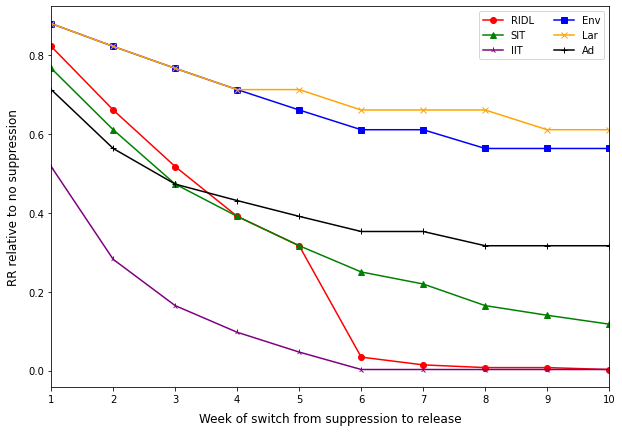

In [697]:
fig, ax2 = plt.subplots(figsize=(10,7))

#plt.margins(x=0,y=0)
ax2.plot(t,w1,'red',marker="o",label="RIDL")
ax2.plot(t,w2,'green',marker="^",label="SIT")
ax2.plot(t,w3,'purple',marker="2",label="IIT")
ax2.plot(t,w4,'blue',marker="s",label="Env")
ax2.plot(t,w5,'orange',marker="x",label="Lar")
ax2.plot(t,w6,'black',marker="+",label="Ad")
plt.xticks(np.linspace(1,10,10))
ax2.set_xlim(1,10)
ax2.set_xlabel("Week of switch from suppression to release",fontsize=12, labelpad=8)
ax2.set_ylabel("RR relative to no suppression",fontsize=12, labelpad=8)
#ax2.set_ylim(0,0.5)
ax2.legend(loc='upper right', ncol=2)
#ax2.set_title("Minimum RR required to reach 95% fixation\n of Wolbachia within 6 months")
#plt.savefig('RR_by_suppression_weeks_switch_16.8.22.jpeg', dpi=600, bbox_inches='tight',)